# 1. Context and data upload

Data comes from [Seattle Open Data](https://data.seattle.gov/Community/2021-Building-Energy-Benchmarking/bfsh-nrm6).

First step is to connect to the source. Since this data is available via the [Socrata Open Data API (SODA)](https://dev.socrata.com/), and the dataset contains 3663 rows, I indicate a max. value of rows to retrieve greater than 3663. Default value is [1000](https://dev.socrata.com/docs/paging.html).

In [1]:
import pandas as pd

link_source = 'https://data.seattle.gov/resource/bfsh-nrm6.csv'
rows_to_retrieve = '?$limit=5000'

init_data = pd.read_csv(link_source+rows_to_retrieve)

# Let's have a look at the shape:
print("This dataset contains {} rows and {} columns".format(
    init_data.shape[0], init_data.shape[1]))

This dataset contains 3663 rows and 42 columns


In [2]:
# Display all the columns for analysis
pd.set_option('display.max_columns', init_data.shape[1]+1)
# Set the column width (defaults to 50)
#pd.set_option('display.max_colwidth', 40)

init_data.head()

,osebuildingid,datayear,buildingname,buildingtype,taxparcelidentificationnumber,address,city,state,zipcode,latitude,longitude,neighborhood,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteeuiwn_kbtu_sf,siteeui_kbtu_sf,siteenergyuse_kbtu,siteenergyusewn_kbtu,sourceeuiwn_kbtu_sf,sourceeui_kbtu_sf,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,electricity_kwh,steamuse_kbtu,naturalgas_therms,compliancestatus,complianceissue,electricity_kbtu,naturalgas_kbtu,totalghgemissions,ghgemissionsintensity
0,1,2021,MAYFLOWER PARK HOTEL,NonResidential,659000030,405 OLIVE WAY,SEATTLE,WA,98101,47.61220,-122.33799,DOWNTOWN,1,1927,12,1,88434,88434,0,78,73.800003,73.599998,6510477,6522024,144.399994,144.199997,Hotel,Hotel,88434,NaN,0,NaN,0,944955,1798672,14876,Compliant,No Issue,3224187,1487620,241.6,2.7
1,2,2021,PARAMOUNT HOTEL,NonResidential,659000220,724 PINE ST,SEATTLE,WA,98101,47.61307,-122.33361,DOWNTOWN,1,1996,11,1,103566,88502,15064,96,52.200001,52.200001,4617104,4617104,99.099998,99.099998,Hotel,Hotel,88502,Parking,15064,NaN,0,657478,0,23738,Compliant,No Issue,2243315,2373790,135.4,1.5
2,3,2021,WESTIN HOTEL (Parent Building),NonResidential,659000475,1900 5TH AVE,SEATTLE,WA,98101,47.61367,-122.33822,DOWNTOWN,1,1969,41,3,956110,759392,196718,96,46.500000,46.500000,43953212,43953212,105.300003,105.300003,Hotel,Hotel,945349,Parking,117783,Swimming Pool,0,8673722,10583473,37750,Compliant,No Issue,29594739,3775000,1201.4,1.6
3,5,2021,HOTEL MAX,NonResidential,659000640,620 STEWART ST,SEATTLE,WA,98101,47.61412,-122.33664,DOWNTOWN,1,1926,10,1,61320,61320,0,76,79.500000,79.500000,4873753,4873753,136.000000,136.000000,Hotel,Hotel,61320,NaN,0,NaN,0,509497,1167770,19676,Compliant,No Issue,1738403,1967580,208.6,3.4
4,8,2021,WARWICK SEATTLE HOTEL,NonResidential,659000970,401 LENORA ST,SEATTLE,WA,98121,47.61375,-122.34047,DOWNTOWN,1,1980,18,1,175580,113580,62000,90,92.400002,92.000000,11358936,11409090,161.500000,161.100006,Hotel,Hotel,123445,Parking,68009,Swimming Pool,0,1333597,0,68087,Compliant,No Issue,4550233,6808700,380.4,3.3


# 2. Overview of the data and pre-selection of columns

First, it is important to note that only the __non-residential__ data should be used here (for this specific project).

The aim here is to predict the __CO2 emissions__ and the __total energy consumption__ for the non-residential buildings. It should be based on structural data (size and usage of the buildings, construction date, location, etc).
- It is interesting to note that: SiteEnergyUse(kBtu) ~= Electricity(kBtu) + SteamUse(kBtu) + NaturalGas(kBtu)
- The sum is not exactly equal (this can be verified by creating a calculated column), maybe there is some rounding errors.

It is also important to evalutate the __ENERGY STAR Score__'s utility here, and its predictive power.

In [3]:
init_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3663 entries, 0 to 3662
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   osebuildingid                   3663 non-null   int64  
 1   datayear                        3663 non-null   int64  
 2   buildingname                    3663 non-null   object 
 3   buildingtype                    3663 non-null   object 
 4   taxparcelidentificationnumber   3663 non-null   object 
 5   address                         3663 non-null   object 
 6   city                            3663 non-null   object 
 7   state                           3663 non-null   object 
 8   zipcode                         3663 non-null   int64  
 9   latitude                        3663 non-null   float64
 10  longitude                       3663 non-null   float64
 11  neighborhood                    3661 non-null   object 
 12  councildistrictcode             36

In [4]:
# First, let's remove the duplicate rows (if any).

# Make a copy:
copy_dedup = init_data.copy()

print(f'Rows before dedup: {init_data.shape[0]}')
# Ignore_index to reset the index:
copy_dedup.drop_duplicates(inplace=True, ignore_index=True)
print(f'Rows after dedup: {copy_dedup.shape[0]}')

Rows before dedup: 3663
Rows after dedup: 3663


There are none, great!

## 2.1. Selecting the non-residential rows

In [5]:
# Let's check the BuildingType
col_ = 'buildingtype'

init_data[col_].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [6]:
# Let's drop the rows that are residential
# I'm assuming SPS stands for Seattle Public Schools
to_drop = ['Multifamily MR (5-9)', 'Multifamily LR (1-4)',
           'Multifamily HR (10+)']

nonRes_data = init_data[~init_data[col_].isin(to_drop)]
nonRes_data.shape

(1700, 42)

In [7]:
# Quick check
nonRes_data[col_].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

## 2.2. Selecting the rows for CO2 emissions, total energy consumption and ENERGY STAR Score

In [8]:
# Define the variables to check for
co2_indic = 'totalghgemissions'
energy_indic = 'siteenergyuse_kbtu'
energy_star = 'energystarscore'

The indicator for the CO2 might not be the best one as-is since it also contains methane and nitrous oxide, but it's not  clear what to substract to get the exact value for the CO2 emissions here.

In [9]:
# Let's count how many rows contain at least 1 of the 3 variables empty
len(nonRes_data[nonRes_data[co2_indic].isna() |
                nonRes_data[energy_indic].isna() |
                nonRes_data[energy_star].isna()])

0

Looks like there are none, great!

## 2.3. Removing the columns related to the previously selected indicators to prevent data-leakage

In [10]:
# Remove columns deducible from other columns,
# or that shouldn't be known in advance
dataleak_cols = ['siteeuiwn_kbtu_sf', 'siteeui_kbtu_sf', 'siteenergyusewn_kbtu',
                 'sourceeuiwn_kbtu_sf', 'sourceeui_kbtu_sf', 'electricity_kwh',
                 'steamuse_kbtu', 'naturalgas_therms', 'electricity_kbtu',
                 'naturalgas_kbtu', 'ghgemissionsintensity']

init_no_dl = nonRes_data.drop(columns=dataleak_cols)
init_no_dl.shape

(1700, 31)

## 2.4. 'Object' columns

In [11]:
# Now, let's investigate the 'object' columns for the modalities
obj_data = init_no_dl.select_dtypes(include='object')

# Print the shape and show a sample
print("This dataset contains {} rows and {} columns\n".format(
    obj_data.shape[0], obj_data.shape[1]))
obj_data.head()

This dataset contains 1700 rows and 13 columns



,buildingname,buildingtype,taxparcelidentificationnumber,address,city,state,neighborhood,epapropertytype,largestpropertyusetype,secondlargestpropertyusetype,thirdlargestpropertyusetype,compliancestatus,complianceissue
0,MAYFLOWER PARK HOTEL,NonResidential,659000030,405 OLIVE WAY,SEATTLE,WA,DOWNTOWN,Hotel,Hotel,NaN,NaN,Compliant,No Issue
1,PARAMOUNT HOTEL,NonResidential,659000220,724 PINE ST,SEATTLE,WA,DOWNTOWN,Hotel,Hotel,Parking,NaN,Compliant,No Issue
2,WESTIN HOTEL (Parent Building),NonResidential,659000475,1900 5TH AVE,SEATTLE,WA,DOWNTOWN,Hotel,Hotel,Parking,Swimming Pool,Compliant,No Issue
3,HOTEL MAX,NonResidential,659000640,620 STEWART ST,SEATTLE,WA,DOWNTOWN,Hotel,Hotel,NaN,NaN,Compliant,No Issue
4,WARWICK SEATTLE HOTEL,NonResidential,659000970,401 LENORA ST,SEATTLE,WA,DOWNTOWN,Hotel,Hotel,Parking,Swimming Pool,Compliant,No Issue


### Building Name

In [12]:
# This should not be relevant here, unless the aim is to "point out" some
# buildings that are "outliers" and help them reduce whatever is not good.
# I just count the number of different building names:
col_ = 'buildingname'

len(obj_data[col_].unique())

1669

Looks like there are some duplicates, it could be because of brands which do not share the same address.

In [13]:
# Then, I drop the column:
sub_df_1 = init_no_dl.drop(columns=col_)
obj_data = obj_data.drop(columns=col_).copy()
sub_df_1.shape

(1700, 30)

### Tax Parcel ID

In [14]:
# Let's also count the number of different parcel ID:
col_ = 'taxparcelidentificationnumber'

len(obj_data[col_].unique())

1602

In [15]:
# Let's investigate some of the duplicates:
obj_data[obj_data.duplicated([col_])].head()

,buildingtype,taxparcelidentificationnumber,address,city,state,neighborhood,epapropertytype,largestpropertyusetype,secondlargestpropertyusetype,thirdlargestpropertyusetype,compliancestatus,complianceissue
109,NonResidential,7378600265,3802 S OTHELLO ST,SEATTLE,WA,GREATER DUWAMISH,Other - Lodging/Residential,Other - Lodging/Residential,Office,Food Service,Compliant,No Issue
128,NonResidential,3624039009,2600 SW BARTON ST,SEATTLE,WA,DELRIDGE NEIGHBORHOODS,Retail Store,Retail Store,NaN,NaN,Not Compliant,Portfolio Manager Account Not Shared
147,Nonresidential COS,7666205660,400 S SPOKANE ST,SEATTLE,WA,GREATER DUWAMISH,Other - Utility,Other - Utility,"Repair Services (Vehicle, Shoe, Locksmith, etc.)",NaN,Compliant,No Issue
197,NonResidential,9301500000,1601 5TH AVE,SEATTLE,WA,DOWNTOWN,Office,Office,Parking,NaN,Compliant,No Issue
252,NonResidential,2400002,1200 5TH AVE,SEATTLE,WA,DOWNTOWN,Office,Office,Parking,Other - Restaurant/Bar,Compliant,No Issue


In [16]:
# Pick one ID to investigate:
init_no_dl[init_no_dl[col_]=='3624039009']

,osebuildingid,datayear,buildingname,buildingtype,taxparcelidentificationnumber,address,city,state,zipcode,latitude,longitude,neighborhood,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,compliancestatus,complianceissue,totalghgemissions
127,223,2021,WESTWOOD VILLAGE - BLDG A,NonResidential,3624039009,2600 SW BARTON ST,SEATTLE,WA,98126,47.52254,-122.36627,DELRIDGE NEIGHBORHOODS,1,1966,1,1,64984,64984,0,0,2581250,Retail Store,Retail Store,65195,NaN,0,NaN,0,Not Compliant,Portfolio Manager Account Not Shared,41.8
128,224,2021,WESTWOOD VILLAGE - BLDG B,NonResidential,3624039009,2600 SW BARTON ST,SEATTLE,WA,98126,47.52254,-122.36627,DELRIDGE NEIGHBORHOODS,1,1965,1,1,67745,67745,0,0,7444998,Retail Store,Retail Store,67763,NaN,0,NaN,0,Not Compliant,Portfolio Manager Account Not Shared,339.9
2130,24636,2021,WESTWOOD VILLAGE - BUILDING E,NonResidential,3624039009,2600 SW BARTON ST,SEATTLE,WA,98126,47.52254,-122.36627,DELRIDGE NEIGHBORHOODS,1,1990,1,1,40265,40265,0,42,2452712,Retail Store,Retail Store,40793,NaN,0,NaN,0,Not Compliant,Portfolio Manager Account Not Shared,32.2
2131,24640,2021,WESTWOOD VILLAGE - BUILDING F,NonResidential,3624039009,2600 SW BARTON ST,SEATTLE,WA,98126,47.52254,-122.36627,DELRIDGE NEIGHBORHOODS,1,2005,1,1,26208,26208,0,74,1581233,Retail Store,Retail Store,32427,NaN,0,NaN,0,Not Compliant,Portfolio Manager Account Not Shared,35.3


This could be investigated further, but it looks like these are different buildings/parts of a building.

Also, this should not be a meaningful feature as-is, because each row has its own "energy use" value, so they can be considered separate.
- In case this assumption is wrong, add the feature back or find a way to create a new feature that could be used.

In [17]:
# I also remove this column:
sub_df_2 = sub_df_1.drop(columns=col_)
obj_data = obj_data.drop(columns=col_).copy()
sub_df_2.shape

(1700, 29)

### Address

In [18]:
# Check the Address
col_ = 'address'

len(obj_data[col_].unique())

1649

In [19]:
# The information from the coordinates coupled with the Postal Code
# should be enough, + there could be some privacy concern, so I drop it:
sub_df_3 = sub_df_2.drop(columns=col_)
obj_data = obj_data.drop(columns=col_).copy()
sub_df_3.shape

(1700, 28)

### City
- Data comes from Seattle, so we expect this value

In [20]:
# Check the City
col_ = 'city'

obj_data[col_].unique()

array(['SEATTLE', '0', 'Seattle'], dtype=object)

In [21]:
# This is to be expected considering the data (from Seattle).
# I can drop this column:
sub_df_4 = sub_df_3.drop(columns=col_)
obj_data = obj_data.drop(columns=col_).copy()
sub_df_4.shape

(1700, 27)

### State
- Seattle is in Washington, so that's the value we expect

In [22]:
# Check the State
col_ = 'state'

obj_data[col_].unique()

array(['WA', '0'], dtype=object)

In [23]:
# Same thing as for the City here. I can drop this column:
sub_df_5 = sub_df_4.drop(columns=col_)
obj_data = obj_data.drop(columns=col_).copy()
sub_df_5.shape

(1700, 26)

### Neighborhood
- See: https://www.seattle.gov/neighborhoods/about-seattle/neighborhoods-and-council-districts

In [24]:
# Check the Neighborhood
col_ = 'neighborhood'

obj_data[col_].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST',
       'SHARED: CENTRAL & EAST', 'NORTH', 'MAGNOLIA / QUEEN ANNE',
       'LAKE UNION', 'GREATER DUWAMISH', 'BALLARD', 'NORTHWEST',
       'CENTRAL', 'SOUTHWEST', 'DELRIDGE NEIGHBORHOODS',
       'SHARED: NORTH & NORTHWEST',
       'SHARED: GREATER DUWAMISH & DELRIDGE NEIGHBORHOODS',
       'SHARED: BALLARD & LAKE UNION', 'SHARED: LAKE UNION & NORTHWEST',
       'SHARED: BALLARD & NORTHWEST', 'water', nan], dtype=object)

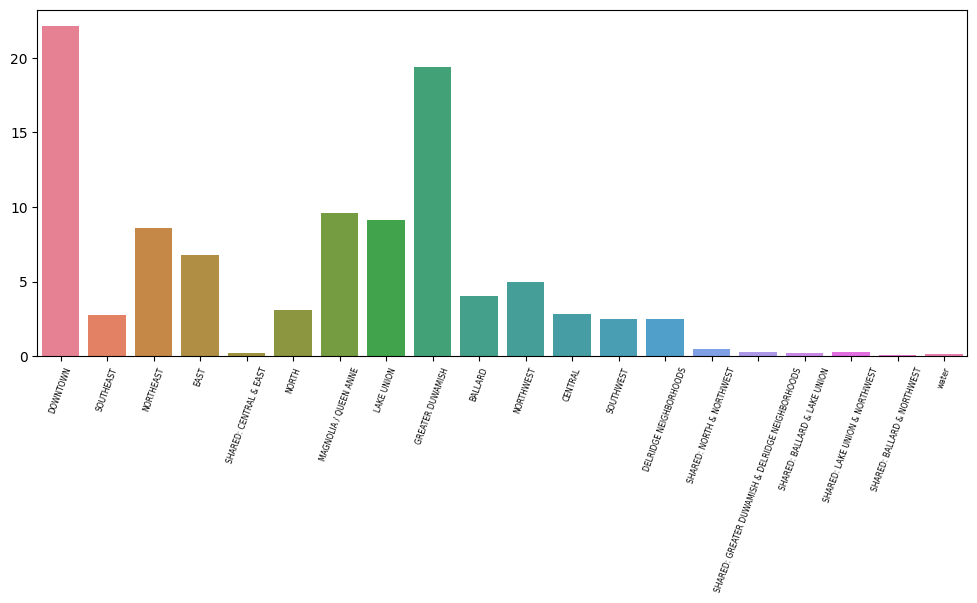

In [25]:
# Let's plot their repartition:
import matplotlib.pyplot as plt
import seaborn as sns

# Dimensions of the plot
plt.rcParams['figure.figsize'] = (12,4.5)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Create the plot
sns.countplot(data=obj_data, x=col_, hue=col_, stat='percent', legend=False)
# Rotate the labels on x axis
plt.xticks(rotation=70, fontsize=5.5)
# Remove the 'titles' of the x and y axis
plt.xlabel('')
plt.ylabel('')
# Display
plt.show()

In [26]:
# To reduce the number of modalities, I group some of them:
grouped_ = 'SHARED_LOC'

conversion_dict = {
    'SHARED: CENTRAL & EAST': grouped_,
    'SHARED: NORTH & NORTHWEST': grouped_,
    'SHARED: GREATER DUWAMISH & DELRIDGE NEIGHBORHOODS': grouped_,
    'SHARED: BALLARD & LAKE UNION': grouped_,
    'SHARED: LAKE UNION & NORTHWEST': grouped_,
    'SHARED: BALLARD & NORTHWEST': grouped_,
    'water': 'WATER'
}

# Then apply the grouping:
sub_df_5[col_] = sub_df_5[col_].replace(conversion_dict).copy()
obj_data[col_] = obj_data[col_].replace(conversion_dict).copy()

In [27]:
# Actually, I'll start by using the District Code only.
# Add back to refine the analysis (and then encode):
sub_df_6 = sub_df_5.drop(columns=col_)
obj_data = obj_data.drop(columns=col_).copy()
sub_df_6.shape

(1700, 25)

### EPAPropertyType (primary use of a property)

In [28]:
# Check the EPA
col_ = 'epapropertytype'

obj_data[col_].unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Library', 'Fitness Center/Health Club/Gym', 'Mixed Use Property',
       'Courthouse', 'Prison/Incarceration', 'K-12 School',
       'College/University', 'Office', 'Self-Storage Facility',
       'Other - Mall', nan, 'Parking', 'Medical Office', 'Other',
       'Social/Meeting Hall', 'Performing Arts', 'Data Center',
       'Supermarket/Grocery Store', 'Multifamily Housing',
       'Hospital (General Medical & Surgical)', 'Fire Station', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Worship Facility', 'Other - Lodging/Residential',
       'Non-Refrigerated Warehouse', 'Retail Store', 'Financial Office',
       'Manufacturing/Industrial Plant', 'Other - Utility',
       'Residence Hall/Dormitory', 'Enclosed Mall', 'Laboratory',
       'Convention Center', 'Outpatient Rehabilitation/Physical Therapy',
       'Distribution Center', 'Other/Specialty Hospital',
       'Other - S

In [29]:
# I notice that some rows have 'Parking' as the EPA. Let's investigate:
len(obj_data[obj_data[col_]=='Parking'])

20

In [30]:
# Let's see some of these:
sub_df_6[sub_df_6[col_]=='Parking'].head()

,osebuildingid,datayear,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,compliancestatus,complianceissue,totalghgemissions
61,89,2021,NonResidential,98122,47.61244,-122.32140,1,1965,3,2,329489,179014,150475,0,20097586,Parking,Parking,150475,Medical Office,115149,NaN,0,Compliant,No Issue,619.4
154,263,2021,NonResidential,98125,47.70281,-122.32532,1,2008,6,1,423569,88460,335109,0,6601776,Parking,Parking,335109,Movie Theater,67074,Medical Office,13567,Compliant,No Issue,144.5
282,420,2021,NonResidential,98101,47.61164,-122.33446,7,1996,6,1,147852,61423,86429,0,5185310,Parking,Parking,64821,Retail Store,40629,Other - Restaurant/Bar,13039,Compliant,No Issue,77.9
283,421,2021,NonResidential,98101,47.61185,-122.33421,7,1996,4,1,267335,100375,166960,0,8096175,Parking,Parking,166960,Movie Theater,72975,Other - Restaurant/Bar,27400,Compliant,No Issue,145.6
360,524,2021,NonResidential,98103,47.64882,-122.34905,6,1999,4,1,243334,140302,103032,0,3818811,Parking,Parking,156528,Office,141860,NaN,0,Not Compliant,Account Requires Verification,15.8


In [31]:
# I suppose this could have a (negative) impact on this study (low consumption),
# so I just remove these rows:
sub_df_7 = sub_df_6[sub_df_6[col_]!='Parking']
obj_data = obj_data[obj_data[col_]!='Parking']
sub_df_7.shape

(1680, 25)

Then, I am using the grid from [this link](https://www.energystar.gov/buildings/benchmark/understand_metrics/what_eui) (ENERGYSTAR Score) to help remove the residential rows.

In [32]:
# That's a long list that I might rework (do some grouping), but not for now.
# I see some housing/residential related rows, let's investigate:

# Define the "abnormal" values:
residential_list = ['Barracks', 'Hotel', 'Multifamily Housing',
                    'Prison/Incarceration', 'Residence Hall/Dormitory',
                    'Residential Care Facility', 'Other - Lodging/Residential']

# Let's count how many rows there are, and show a sample:
print('There are {} abnormal rows\nHere\'s a sample:\n'.format(
    len(sub_df_7[sub_df_7[col_].isin(residential_list)])))
sub_df_7[sub_df_7[col_].isin(residential_list)].sample(n=5, random_state=23)

There are 112 abnormal rows
Here's a sample:



,osebuildingid,datayear,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,compliancestatus,complianceissue,totalghgemissions
186,314,2021,NonResidential,98121,47.61235,-122.35180,1,1961,4,1,122309,122309,0,41,18285032,Hotel,Hotel,122309,NaN,0,NaN,0,Compliant,No Issue,722.9
1538,22482,2021,NonResidential,98119,47.64978,-122.37713,1,2017,8,1,250867,184276,66591,98,6392967,Multifamily Housing,Multifamily Housing,219220,NaN,0,NaN,0,Compliant,No Issue,149.2
53,70,2021,NonResidential,98119,47.62023,-122.35951,1,1998,6,1,155602,118858,36744,63,6761224,Hotel,Hotel,118858,Parking,36744,NaN,0,Compliant,No Issue,155.2
48,63,2021,Campus,98101,47.61087,-122.33339,1,1982,34,2,1083197,926614,156583,91,56395556,Hotel,Hotel,994212,Parking,117668,Swimming Pool,0,Compliant,No Issue,1385.4
2735,26911,2021,NonResidential,98105,47.66164,-122.30874,4,1926,4,1,23616,23616,0,62,1774326,Residence Hall/Dormitory,Residence Hall/Dormitory,23616,NaN,0,NaN,0,Compliant,No Issue,61.2


In [33]:
# Without further knowledge, I'll assume this is a misclassification of the
# BuildingType and drop these rows:
sub_df_8 = sub_df_7[~sub_df_7[col_].isin(residential_list)]
obj_data = obj_data[~obj_data[col_].isin(residential_list)]
sub_df_8.shape

(1568, 25)

In [34]:
# I also replace the 'nan' by 'UNK' (UNKnown)
sub_df_9 = sub_df_8.copy()
sub_df_9[col_] = sub_df_8[col_].fillna('UNK')
obj_data[col_] = obj_data[col_].fillna('UNK')

<ipython-input-34-02667e61d966>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj_data[col_] = obj_data[col_].fillna('UNK')


### Largest Property Use Type

In [35]:
# Check the Largest Property Use Type
col_ = 'largestpropertyusetype'

obj_data[col_].unique()

array(['Police Station', 'Other - Entertainment/Public Assembly',
       'Library', 'Fitness Center/Health Club/Gym', 'Social/Meeting Hall',
       'Courthouse', 'K-12 School', 'College/University', 'Office',
       'Self-Storage Facility', 'Other - Mall', 'Senior Living Community',
       'Medical Office', 'Other', 'Performing Arts', 'Data Center',
       'Supermarket/Grocery Store',
       'Hospital (General Medical & Surgical)', 'Fire Station', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc.)',
       'Worship Facility', 'Non-Refrigerated Warehouse', 'Retail Store',
       'Financial Office', 'Manufacturing/Industrial Plant',
       'Other - Utility', 'Transportation Terminal/Station', 'Laboratory',
       'Convention Center', 'Restaurant', 'Enclosed Mall', nan, 'Parking',
       'Outpatient Rehabilitation/Physical Therapy',
       'Distribution Center', 'Other/Specialty Hospital',
       'Other - Services', 'Strip Mall', 'Refrigerated Warehouse',
       'Urgent Ca

In [36]:
# Again, I notice that some rows have 'Parking' as the Largest Prop. Use:
len(obj_data[obj_data[col_]=='Parking'])

13

In [37]:
# Let's see some of these:
sub_df_9[sub_df_9[col_]=='Parking'].head()

,osebuildingid,datayear,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,compliancestatus,complianceissue,totalghgemissions
239,371,2021,NonResidential,98101,47.61770,-122.33060,1,2000,11,1,380312,184691,195621,81,9411945,Mixed Use Property,Parking,182820,Office,165558,Fitness Center/Health Club/Gym,39024,Compliant,No Issue,39.5
341,494,2021,NonResidential,98105,47.65821,-122.31831,1,1988,4,1,196749,108344,88405,0,17079152,Mixed Use Property,Parking,88405,Medical Office,73344,Laboratory,35000,Compliant,No Issue,413.8
412,588,2021,NonResidential,98102,47.63456,-122.32454,1,2002,5,1,281306,167988,113318,0,45401348,Mixed Use Property,Parking,96939,Laboratory,84000,Office,84000,Compliant,No Issue,947.4
467,657,2021,NonResidential,98121,47.61783,-122.33729,1,2006,0,1,516407,516407,0,93,34618024,Mixed Use Property,Parking,385196,Multifamily Housing,340236,Hotel,80067,Compliant,No Issue,1005.0
542,757,2021,NonResidential,98121,47.61051,-122.34439,7,1979,7,1,131143,43983,87160,76,9257442,Mixed Use Property,Parking,132780,Office,127013,Restaurant,21642,Compliant,No Issue,218.4


In [38]:
# Here, for the sake of simplicity, and since it's only 13 rows, I remove them:
sub_df_10 = sub_df_9[sub_df_9[col_]!='Parking']
obj_data = obj_data[obj_data[col_]!='Parking']
sub_df_10.shape

(1555, 25)

This list (as well as the 2nd and 3rd largest use type) should be aligned to the EPA Property Type (ideally). For now I'll just continue the analysis as-is, but this is a consideration for improvement.

In [39]:
# I see some housing/residential related rows, let's investigate:

# Define the "abnormal" values. Adding one more:
residential_list.append('Senior Living Community')

# Let's count how many rows there are, and show a sample:
print('There are {} abnormal rows\nHere\'s a sample:'.format(
    len(sub_df_10[sub_df_10[col_].isin(residential_list)])))
sub_df_10[sub_df_10[col_].isin(residential_list)].head()

There are 29 abnormal rows
Here's a sample:


,osebuildingid,datayear,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,compliancestatus,complianceissue,totalghgemissions
57,84,2021,NonResidential,98126,47.55837,-122.37751,1,1922,5,1,371257,296313,74944,44,44967996,UNK,Senior Living Community,296313,Parking,0,NaN,0,Compliant,No Issue,1862.0
58,85,2021,NonResidential,98133,47.72426,-122.35599,1,1970,2,1,93397,93397,0,1,15596807,UNK,Senior Living Community,93397,NaN,0,NaN,0,Compliant,No Issue,571.8
163,278,2021,NonResidential,98134,47.59626,-122.32180,1,1999,5,1,102796,90185,12611,0,8770639,UNK,Senior Living Community,55259,Medical Office,40091,K-12 School,3231,Not Compliant,Default Data,133.9
864,20145,2021,NonResidential,98104,47.60897,-122.32507,3,2006,6,1,62334,51457,10877,0,2996646,UNK,Senior Living Community,47805,Parking,10877,Bank Branch,3552,Compliant,No Issue,53.5
941,20377,2021,NonResidential,98144,47.57188,-122.29531,1,1981,3,1,58665,58665,0,50,7595482,UNK,Senior Living Community,78374,Parking,0,NaN,0,Compliant,No Issue,237.4


In [40]:
# Without further knowledge, I'll assume this is a misclassification and
# drop these rows:
sub_df_11 = sub_df_10[~sub_df_10[col_].isin(residential_list)]
obj_data = obj_data[~obj_data[col_].isin(residential_list)]
sub_df_11.shape

(1526, 25)

In [41]:
# I also noticed some missing values
print('There are {} lines with {} missing. Here\'s a sample:\n'.format(
    len(sub_df_11[sub_df_11[col_].isna()]), col_))
sub_df_11[sub_df_11[col_].isna()].head()

There are 21 lines with largestpropertyusetype missing. Here's a sample:



,osebuildingid,datayear,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,compliancestatus,complianceissue,totalghgemissions
211,340,2021,NonResidential,98104,47.60219,-122.33347,1,1900,6,1,89355,89355,0,0,0,UNK,NaN,0,NaN,0,NaN,0,Not Compliant,Portfolio Manager Account Not Shared,0.0
325,473,2021,NonResidential,98109,47.62383,-122.33560,7,2009,5,1,271071,172371,98700,0,0,UNK,NaN,0,NaN,0,NaN,0,Contact the Help Desk,Unknown - Contact the Help Desk,0.0
352,514,2021,NonResidential,98133,47.72053,-122.34739,1,1997,1,1,131387,131387,0,0,0,UNK,NaN,0,NaN,0,NaN,0,Contact the Help Desk,Unknown - Contact the Help Desk,0.0
402,576,2021,NonResidential,98125,47.70940,-122.31843,1,1969,2,1,98539,98539,0,0,0,UNK,NaN,0,NaN,0,NaN,0,Not Compliant,Portfolio Manager Account Not Shared,0.0
609,851,2021,NonResidential,98144,47.59970,-122.30364,1,1974,4,2,114000,114000,0,0,0,UNK,NaN,0,NaN,0,NaN,0,Not Compliant,Portfolio Manager Account Not Shared,0.0


In [42]:
# Since the EPA doesn't help, I also fill with UNK:
sub_df_12 = sub_df_11.copy()
sub_df_12[col_] = sub_df_11[col_].fillna('UNK')
obj_data[col_] = obj_data[col_].fillna('UNK')

<ipython-input-42-8d5eb9084380>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj_data[col_] = obj_data[col_].fillna('UNK')


In [43]:
# I also noticed that some rows have
# LargestPropertyUseTypeGFA > PropertyGFATotal:
cond_ = sub_df_12['largestpropertyusetypegfa']>sub_df_12['propertygfatotal']

len(sub_df_12[cond_])

233

In [44]:
# Let's see a sample:
sub_df_12[cond_].sample(n=5, random_state=23)

,osebuildingid,datayear,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,compliancestatus,complianceissue,totalghgemissions
3097,41927,2021,NonResidential,98195,47.65456,-122.30933,1,2011,5,1,90374,90374,0,0,17208350,College/University,College/University,103141,Laboratory,67302,NaN,0,Compliant,No Issue,71.2
42,57,2021,NonResidential,98101,47.61130,-122.33659,1,1973,5,1,88717,88717,0,70,6566530,Office,Office,103855,Retail Store,65676,Data Center,493,Compliant,No Issue,27.2
106,177,2021,SPS-District K-12,98122,47.61224,-122.29087,1,2002,3,1,66994,66994,0,47,3166253,K-12 School,K-12 School,68127,NaN,0,NaN,0,Compliant,No Issue,66.0
334,487,2021,NonResidential,98109,47.62405,-122.34036,1,1963,4,1,102235,102235,0,0,23657828,Laboratory,Laboratory,103135,NaN,0,NaN,0,Compliant,No Issue,567.4
189,317,2021,Nonresidential COS,98101,47.60729,-122.34211,1,1980,2,1,53365,53365,0,0,20150314,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,69400,NaN,0,NaN,0,Compliant,No Issue,521.7


There are a few ways to fix this:
- remove the rows: but since it's too many of them, I don't consider this option,
- consider that the true value is PropertyGFATotal, but since it's lower than LargestPropertyUseGFA that seems troublesome to do,
- consider that the true value are the PropertyUseGFA (larg, 2nd), and update PropertyGFATotal (and _maybe_ PropertyGFABuildings?) using the other columns, which is the option I keep.

This really is an issue that should be investigated at the source, because I might be propagating the incoherences, if any, from the columns I use.

<u>Note:</u> I am not using the thirdlargestpropertyusetypegfa because I will drop that column later, for being too empty.

In [45]:
# Define the columns of interest
col_tot = 'propertygfatotal'
col_1st = 'largestpropertyusetypegfa'
col_2nd = 'secondlargestpropertyuse'

# Define the new total
sub_df_12['new_total'] = sub_df_12[col_1st] + sub_df_12[col_2nd]

In [46]:
# Replace the values appropriately
sub_df_12.loc[cond_, col_tot] = sub_df_12.loc[cond_, 'new_total']

# Then drop the column created
sub_df_13 = sub_df_12.drop(columns='new_total')

In [47]:
# Check that it is fixed.
# No error should be returned here:
assert sum((sub_df_13[col_tot] >= sub_df_13[col_1st])) == len(sub_df_13)

### 2nd Largest Property Use Type

In [48]:
# Check the 2nd Largest Property Use Type
col_ = 'secondlargestpropertyusetype'

obj_data[col_].unique()

array(['Parking', nan, 'Office', 'Restaurant', 'Barracks', 'K-12 School',
       'Laboratory', 'Non-Refrigerated Warehouse', 'Other - Education',
       'Vocational School', 'Retail Store',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Performing Arts', 'Data Center', 'Medical Office',
       'Residence Hall/Dormitory', 'Distribution Center',
       'Repair Services (Vehicle, Shoe, Locksmith, etc.)',
       'Multifamily Housing', 'Other', 'Transportation Terminal/Station',
       'Other - Services', 'Other - Recreation', 'Food Service',
       'College/University', 'Hotel', 'Other - Restaurant/Bar',
       'Supermarket/Grocery Store', 'Adult Education',
       'Fitness Center/Health Club/Gym', 'Refrigerated Warehouse',
       'Library', 'Outpatient Rehabilitation/Physical Therapy',
       'Manufacturing/Industrial Plant', 'Social/Meeting Hall',
       'Enclosed Mall', 'Bar/Nightclub',
       'Other - Entertainment/Public Assembly', 'Self-Storage Facility',
    

In [49]:
# Again, I notice that some rows have 'Parking' as the Largest Prop. Use:
len(obj_data[obj_data[col_]=='Parking'])

377

There are too many rows to remove without losing too much information, so I leave it as-is.

In [50]:
# I see some housing/residential related rows, let's investigate:

# Let's count how many rows there are, and show a sample:
print('There are {} abnormal rows\nHere\'s a sample:'.format(
    len(sub_df_13[sub_df_13[col_].isin(residential_list)])))
sub_df_13[sub_df_13[col_].isin(residential_list)].head()

There are 16 abnormal rows
Here's a sample:


,osebuildingid,datayear,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,thirdlargestpropertyusetype,thirdlargestpropertyusetypegfa,compliancestatus,complianceissue,totalghgemissions
20,26,2021,NonResidential,98104,47.60265,-122.33051,1,1916,10,1,540360,540360,0,42,63318804,Courthouse,Courthouse,501287,Barracks,35863,NaN,0,Compliant,No Issue,1979.7
137,234,2021,Nonresidential COS,98109,47.62552,-122.34064,1,1926,2,1,50292,50292,0,0,0,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,38693,Residence Hall/Dormitory,5000,Office,4730,Compliant,No Issue,0.0
155,264,2021,NonResidential,98119,47.62390,-122.35756,1,2002,4,1,82061,42882,39179,0,7619336,Supermarket/Grocery Store,Supermarket/Grocery Store,76268,Multifamily Housing,72564,NaN,0,Not Compliant,Account Requires Verification,31.5
265,401,2021,NonResidential,98101,47.60968,-122.33379,1,1930,21,1,305548,305548,0,94,24048372,Fitness Center/Health Club/Gym,Fitness Center/Health Club/Gym,185292,Hotel,67822,Restaurant,31949,Not Compliant,Default Data,1216.6
492,694,2021,NonResidential,98134,47.57654,-122.32047,1,2007,1,23,213696,213696,0,41,5880402,Office,Office,80157,Multifamily Housing,34302,Non-Refrigerated Warehouse,14900,Compliant,No Issue,54.2


This part would require domain knowledge on how to best handle these rows:
- they could be removed because we do not want any residential building at all,
- they could be removed based on a certain % of the total surface (say, if at least 20% is residential then the row gets removed),
- they could be kept because the main/largest use type is not residential,
- the residential part could be substracted from the total of each row, which would also require to deal with the energy/CO2 values of the rows (which _seems_ feasible but too complicated for now),
- etc

In [51]:
# For now, I just pick the easy way because it's only 16 rows. I drop them:
sub_df_14 = sub_df_13[~sub_df_13[col_].isin(residential_list)]
obj_data = obj_data[~obj_data[col_].isin(residential_list)]
sub_df_14.shape

(1510, 25)

In [52]:
# I also replace the 'nan' by 'UNK'
sub_df_15 = sub_df_14.copy()
sub_df_15[col_] = sub_df_14[col_].fillna('UNK')
obj_data[col_] = obj_data[col_].fillna('UNK')

<ipython-input-52-5e9b49aa9821>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obj_data[col_] = obj_data[col_].fillna('UNK')


### 3rd Largest Property Use Type

In [53]:
# Check for the completion of the column
col_ = 'thirdlargestpropertyusetype'

nb_na = sub_df_15[col_].isna().sum()
length = len(sub_df_15[col_])

print(f'Completion of the column: {(1 - nb_na/length) * 100:.2f}%')

Completion of the column: 20.40%


This column is too empty there, so I just drop it. I consider having enough information with the Largest and 2nd Largest Property Use Type, so I don't create a new column encoding the missingness.

In [54]:
# I also drop the related numeric column:
to_drop = ['thirdlargestpropertyusetype', 'thirdlargestpropertyusetypegfa']

sub_df_16 = sub_df_15.drop(columns=to_drop)
obj_data = obj_data.drop(columns='thirdlargestpropertyusetype')
sub_df_16.shape

(1510, 23)

### Compliance Status & Issue

In [55]:
# Check the Compliance Status
col_ = 'compliancestatus'

obj_data[col_].unique()

array(['Compliant', 'Not Compliant', 'Contact the Help Desk'],
      dtype=object)

In [56]:
# Check the Compliance Issue
col_ = 'complianceissue'

obj_data[col_].unique()

array(['No Issue', 'Portfolio Manager Account Not Shared',
       'Missing 2021 EUI or Electricity Data', 'Default Data',
       'Unknown - Contact the Help Desk', 'Account Requires Verification'],
      dtype=object)

In [57]:
# I'll assume these columns are not helpful for the prediction, so I drop them:
to_drop = ['compliancestatus', 'complianceissue']

sub_df_17 = sub_df_16.drop(columns=to_drop)
obj_data = obj_data.drop(columns=to_drop)
sub_df_17.shape

(1510, 21)

In [58]:
# Finally, let's reset the index
sub_df_18 = sub_df_17.reset_index(drop=True)

## 2.5. Numerical columns

In [59]:
# Let's select the non-'object' columns for the modalities
num_data = sub_df_18.select_dtypes(exclude='object')

# Print the shape and show a sample
print("This dataset contains {} rows and {} columns\n".format(
    num_data.shape[0], num_data.shape[1]))
num_data.head()

This dataset contains 1510 rows and 17 columns



,osebuildingid,datayear,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,largestpropertyusetypegfa,secondlargestpropertyuse,totalghgemissions
0,9,2021,98101,47.61623,-122.33657,1,1999,2,1,97288,60090,37198,0,9832419,50755,40971,196.0
1,11,2021,98101,47.61327,-122.33136,1,1926,8,1,102761,102761,0,0,7262585,102761,0,385.9
2,21,2021,98104,47.60649,-122.33297,1,2004,11,1,412000,355000,57000,0,13394116,364913,49000,108.3
3,22,2021,98104,47.60546,-122.33279,1,1930,6,1,103911,103911,0,0,7162932,61528,32195,263.7
4,24,2021,98104,47.60515,-122.33159,1,1907,5,1,57452,57452,0,0,6043709,16442,15505,223.8


In [60]:
# Define the (approx.) ratio to convert to m2:
sf_to_m2 = 10.76

### OSE Building ID (unique ID)

In [61]:
# Check the unique ID
col_ = 'osebuildingid'

# This should not throw an error (otherwise, there may be some duplicate issue):
assert len(num_data[col_].unique()) == num_data.shape[0]

In [62]:
# The column should not have any predictive power, and can/should be dropped:
sub_df_19 = sub_df_18.drop(columns=col_)
num_data = num_data.drop(columns=col_).copy()
sub_df_19.shape

(1510, 20)

### Data Year
- Data used is from 2021, so that's the value we expect

In [63]:
# Check the year
col_ = 'datayear'

num_data[col_].unique()

array([2021])

In [64]:
# This is to be expected considering the data. I can drop this column:
sub_df_20 = sub_df_19.drop(columns=col_)
num_data = num_data.drop(columns=col_).copy()
sub_df_20.shape

(1510, 19)

### Zipcode

In [65]:
# Check the Zipcode
col_ = 'zipcode'

num_data[col_].unique()

array([98101, 98104, 98118, 98121, 98112, 98125, 98109, 98103, 98105,
       98108, 98199, 98115, 98107, 98144, 98122, 98146, 98119, 98106,
       98133, 98126, 98134, 98117, 98136, 98116, 98177, 98102, 98155,
       98178, 98195,     0])

In [66]:
# Count the rows where the zipcode is '0' and display them:
print(
    f'There are {len(num_data[num_data[col_] == 0])} rows with 0 as Zipcode:\n')
num_data[num_data[col_]==0]

There are 13 rows with 0 as Zipcode:



,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,largestpropertyusetypegfa,secondlargestpropertyuse,totalghgemissions
1375,0,47.65034,-122.30907,1,1960,10,1,1739802,1615291,124511,59,325567936,1615291,124511,14619.9
1431,0,47.61523,-122.33835,1,2016,37,2,1496961,1076961,420000,95,45050740,1023298,448625,519.5
1432,0,47.64790,-122.33814,1,2016,4,1,338989,220902,118087,67,12152586,205727,117684,105.7
1433,0,47.70598,-122.33486,5,2016,2,1,44745,44745,0,95,1711505,44667,0,7.1
1436,0,47.61632,-122.33304,1,2016,21,1,489821,361575,128246,89,15805341,373458,110813,83.2
1437,0,47.66306,-122.30020,1,2016,4,1,47406,47406,0,11,2927390,45000,0,12.1
1438,0,47.66673,-122.38309,6,2016,4,1,37100,37100,0,93,1114496,34350,0,16.0
1439,0,47.63849,-122.37695,1,2016,1,1,25763,25065,0,98,1329135,25763,0,5.5
1440,0,47.70562,-122.32319,0,2005,1,1,20616,20616,0,0,557305,20616,0,2.3
1441,0,47.63191,-122.31523,0,1912,1,1,23445,23445,0,0,7361850,23445,0,364.9


In [67]:
# I could try to deduce the Zipcode through the address or the TaxParcelID,
# but I'll go with the easy (maybe not optimal) solution here: drop the rows:
# (review this if I decide not to use the column later)
sub_df_21 = sub_df_20[sub_df_20[col_]!=0]
num_data = num_data[num_data[col_]!=0].copy()
sub_df_21.shape

(1497, 19)

### Latitude and Longitude
* Latitude should range between -90 and +90
* Longitude should range between -180 and +180
* Seattle coordinates should be around lat. +47 / long. -122

In [68]:
col_lat = 'latitude'
col_long = 'longitude'

# Check the latitude
print('Latitude:\n- Min: {}\n- Max: {}'.format(num_data[col_lat].min(),
                                               num_data[col_lat].max()))
print('\nLongitude:\n- Min: {}\n- Max: {}'.format(num_data[col_long].min(),
                                                  num_data[col_long].max()))

Latitude:
- Min: 0.0
- Max: 47.73387

Longitude:
- Min: -122.41182
- Max: 0.0


In [69]:
# Let's investigate the rows where the Latitude is less than 45:
sub_df_21[sub_df_21[col_lat]<45]

,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions
1392,NonResidential,98146,0.0,0.0,0,2010,2,1,44162,44162,0,0,1597700,Pre-school/Daycare,Pre-school/Daycare,44162,Parking,15761,36.7


In [70]:
# Let's also investigate the rows where the Longitude is greater than -120:
sub_df_21[sub_df_21[col_long]>-120]

,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions
1392,NonResidential,98146,0.0,0.0,0,2010,2,1,44162,44162,0,0,1597700,Pre-school/Daycare,Pre-school/Daycare,44162,Parking,15761,36.7


In [71]:
# Looks like this row needs some fixing, but I'll just remove it:
sub_df_22 = sub_df_21[sub_df_21[col_lat]>45]
num_data = num_data[num_data[col_lat]>45].copy()
sub_df_22.shape

(1496, 19)

### CouncilDistrictCode

In [72]:
# Check the code
col_ = 'councildistrictcode'

num_data[col_].unique()

array([1, 7, 3, 4, 2, 6, 5])

Seems normal.

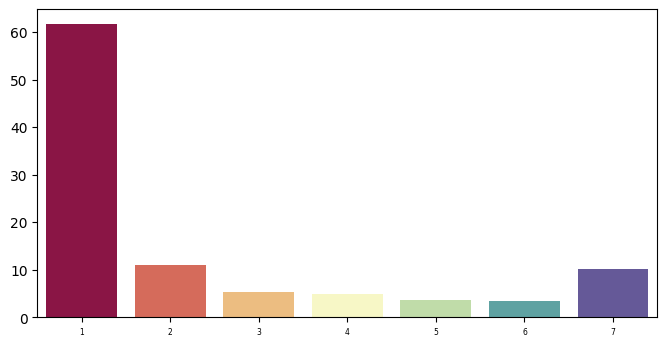

In [73]:
# Let's plot the repartition

# Dimensions of the plot
plt.rcParams['figure.figsize'] = (8,4)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Create the plot
sns.countplot(data=num_data, x=col_, hue=col_, palette='Spectral',
              stat='percent', legend=False)
# Rotate the labels on x axis
plt.xticks(fontsize=5.5)
# Remove the 'titles' of the x and y axis
plt.xlabel('')
plt.ylabel('')
# Display
plt.show()

There is an imbalance here: District 1 is the 'City center'?

### Year Built

In [74]:
# Check the Year Built
col_ = 'yearbuilt'

num_data[col_].unique()

array([1999, 1926, 2004, 1930, 1907, 1961, 1928, 1955, 1949, 1989, 1906,
       1992, 1990, 1950, 1900, 1954, 1911, 1973, 1920, 1910, 1962, 2016,
       1983, 2010, 1938, 1986, 1970, 1923, 1908, 2003, 1991, 1957, 1964,
       1941, 1929, 1963, 1959, 1927, 1998, 2006, 1915, 2002, 2008, 2001,
       2000, 1958, 1980, 2011, 2007, 1951, 1953, 1996, 1952, 1904, 1960,
       1937, 1966, 1965, 1969, 1925, 1924, 1916, 1997, 1972, 2005, 1914,
       1995, 1968, 1981, 1978, 1976, 2009, 1922, 1909, 1971, 1988, 1979,
       1982, 1947, 1984, 1956, 1912, 1977, 1921, 1985, 1913, 1945, 1974,
       1975, 1994, 1946, 1967, 1987, 1932, 1948, 1993, 1918, 1905, 1931,
       1902, 1940, 1939, 1944, 1917, 1942, 1903, 2012, 2013, 1919, 2017,
       1901, 2019, 1936, 1935, 2014, 1896, 2015, 2018, 2020])

In [75]:
# Check for the min and max values
print('Construction year:\n- Oldest: {}\n- Most recent: {}'.format(
    num_data[col_].min(), num_data[col_].max()))

Construction year:
- Oldest: 1896
- Most recent: 2020


Seems normal.

### Number of floors

In [76]:
# Check the # of floors
col_ = 'numberoffloors'

num_data[col_].unique()

array([ 2,  8, 11,  6,  5,  7,  1,  3, 12,  4, 10, 15, 25, 33, 23, 17, 20,
       36, 16, 22, 47, 41, 29, 34, 14, 49, 37, 42, 63, 13, 18, 24, 21, 55,
       46, 30, 56,  9,  0, 19, 27, 76, 38])

In [77]:
# Check for the min and max values
print('Number of floors:\n- Min: {}\n- Max: {}'.format(
    num_data[col_].min(), num_data[col_].max()))

Number of floors:
- Min: 0
- Max: 76


In [78]:
# Count the rows where the # is '0' and display them:
print(
    f'There are {len(num_data[num_data[col_]==0])} rows with 0 as # of floors:\n')
num_data[num_data[col_]==0]

There are 8 rows with 0 as # of floors:



,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,largestpropertyusetypegfa,secondlargestpropertyuse,totalghgemissions
388,98104,47.60979,-122.32298,1,2004,0,1,225982,225982,0,25,25412746,200184,0,1054.1
928,98104,47.60862,-122.32372,1,1975,0,1,383914,227569,156345,62,28010892,233491,135954,1459.8
1003,98134,47.59042,-122.32498,2,1991,0,10,230971,230971,0,0,42557948,196760,0,1762.7
1354,98115,47.68240,-122.26223,4,1960,0,1,30287,30287,0,94,2144492,28050,0,27.9
1355,98115,47.68254,-122.26299,4,1960,0,1,31845,21931,0,30,3996771,31845,0,158.3
1370,98115,47.68212,-122.26330,1,1929,0,7,564258,564258,0,0,20361622,564258,0,624.2
1401,98105,47.65644,-122.31041,1,1900,0,111,15216474,9320156,0,0,0,15216474,0,0.0
1489,98195,47.64846,-122.30003,1,1905,0,1,20904,20904,0,0,0,20904,0,0.0


In [79]:
# This seems to be a mistake. The value could either be 1, or 10, or something
# else that I could fill using an imputer, but for now I just drop these rows:
sub_df_23 = sub_df_22[sub_df_22[col_]!=0]
num_data = num_data[num_data[col_]!=0].copy()
sub_df_23.shape

(1488, 19)

### Number of buildings

In [80]:
# Check the # of buildings
col_ = 'numberofbuildings'

num_data[col_].unique()

array([ 1,  2,  0, 27, 10, 11, 16,  4,  8,  3,  6,  5, 39, 25, 14,  7])

In [81]:
# There are some abnormal values here. Let's check the value 0:
print(
    f'There are {len(num_data[num_data[col_]==0])} rows with 0 as # of buildings:\n')
num_data[num_data[col_]==0]

There are 18 rows with 0 as # of buildings:



,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfatotal,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,largestpropertyusetypegfa,secondlargestpropertyuse,totalghgemissions
49,98126,47.53284,-122.37493,1,1926,3,0,50742,44324,0,0,1742902,50742,0,46.6
50,98119,47.65115,-122.36037,1,1927,2,0,82746,82746,0,0,8804385,82746,0,276.1
261,98109,47.62300,-122.35589,1,1964,4,0,127735,70135,57600,93,3414394,70135,61100,86.3
372,98104,47.59685,-122.33342,1,1904,4,0,83400,83400,0,0,0,83400,0,0.0
526,98144,47.58203,-122.29854,1,1972,1,0,166014,166014,0,39,5800354,166014,0,48.9
584,98101,47.61206,-122.33785,1,1926,4,0,27000,27000,0,0,2815636,16200,5400,53.0
611,98199,47.66304,-122.39169,1,1926,3,0,59805,48560,0,0,3059511,59805,0,12.7
619,98134,47.57411,-122.33715,1,1959,1,0,51610,32192,0,0,7123873,51442,168,304.3
667,98102,47.64596,-122.32628,1,1989,3,0,76245,42420,33825,57,2250568,41117,33825,9.3
722,98133,47.72362,-122.34897,1,1997,1,0,20595,20595,0,0,1656904,20595,0,62.8


In [82]:
# This seems to be a mistake. The value could either be 1, or 10, or something
# else that I could fill using an imputer, but for now I just drop these rows:
sub_df_24 = sub_df_23[sub_df_23[col_]!=0]
num_data = num_data[num_data[col_]!=0].copy()
sub_df_24.shape

(1470, 19)

### Property G<sub>*ross*</sub> F<sub>*loor*</sub> A<sub>*rea*</sub>
- Total
- Building(s)
- Parking

#### GFA total

In [83]:
# Select the GFA total
col_ = 'propertygfatotal'

# Check for the min and max values
print('Prop. GFA total:\n- Min: {:.2f} m2\n- Max: {:.2f} m2'.format(
    num_data[col_].min()/sf_to_m2,
    num_data[col_].max()/sf_to_m2))

Prop. GFA total:
- Min: 1858.74 m2
- Max: 195109.57 m2


#### GFA building(s)

In [84]:
# Select the GFA building(s)
col_ = 'propertygfabuilding_s'

# Check for the min and max values
print('Prop. GFA building(s):\n- Min: {:.2f} m2\n- Max: {:.2f} m2'.format(
    num_data[col_].min()/sf_to_m2,
    num_data[col_].max()/sf_to_m2))

Prop. GFA building(s):
- Min: 1063.20 m2
- Max: 188320.07 m2


#### GFA parking

In [85]:
# Select the GFA parking
col_ = 'propertygfaparking'

# Check for the min and max values
print('Prop. GFA parking:\n- Min: {:.2f} m2\n- Max: {:.2f} m2'.format(
    num_data[col_].min()/sf_to_m2,
    num_data[col_].max()/sf_to_m2))

Prop. GFA parking:
- Min: 0.00 m2
- Max: 63824.35 m2


#### Check that total = buildings + parking

In [86]:
# First make a copy of the data
pgfa_df = sub_df_24.copy()

In [87]:
# Define the columns of interest
p_total = 'propertygfatotal'
p_building = 'propertygfabuilding_s'
p_parking = 'propertygfaparking'

# Calculate the total of building + parking:
pgfa_df['computed_gfa_total'] = pgfa_df[p_building] + pgfa_df[p_parking]

In [88]:
# Now compare the two columns
sum(pgfa_df[p_total] != pgfa_df['computed_gfa_total'])

221

For the lines with a different total, fix considering that:
building = total - parking

This is because I fixed the total [here](#scrollTo=HTAMRzHSnfQr).

In [89]:
# Define the condition
cond_ = sub_df_24[p_total] != sub_df_24[p_building] + sub_df_24[p_parking]

# Define the new gfa_building
sub_df_24['new_gfabuild'] = sub_df_24[p_total] - sub_df_24[p_parking]

# Replace the values appropriately
sub_df_24.loc[cond_, p_building] = sub_df_24.loc[cond_, 'new_gfabuild']

# Then drop the added column
sub_df_25 = sub_df_24.drop(columns='new_gfabuild').copy()

<ipython-input-89-91d5c80cfceb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df_24['new_gfabuild'] = sub_df_24[p_total] - sub_df_24[p_parking]


In [90]:
# # Since these columns carry the same information, I delete the total:
sub_df_26 = sub_df_25.drop(columns=p_total)
num_data = num_data.drop(columns=p_total).copy()
sub_df_26.shape

(1470, 18)

### EnergySTARScore

In [91]:
# Select the score
col_ = 'energystarscore'

# Check for the min and max values
print('EnergySTARScore:\n- Min: {}\n- Max: {}'.format(
    num_data[col_].min(), num_data[col_].max()))

EnergySTARScore:
- Min: 0
- Max: 100


Seems fine.

### Site Energy Use (kBtu)

In [92]:
# Select the Site Energy Use (kBtu)
col_ = 'siteenergyuse_kbtu'

# Check for the min and max values
print('Site Energy Use:\n- Min: {}\n- Max: {}'.format(
    num_data[col_].min(), num_data[col_].max()))

Site Energy Use:
- Min: 0
- Max: 518003488


In [93]:
# Check how many have no consumption:
len(sub_df_26[sub_df_26[col_]<1])

76

In [94]:
# Let's investigate a sample:
sub_df_26[sub_df_26[col_]<1].sample(n=5, random_state=23)

,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions
543,NonResidential,98118,47.51127,-122.28100,1,1967,1,1,48001,0,0,0,UNK,UNK,0,UNK,0,0.0
920,NonResidential,98133,47.72286,-122.34612,1,1979,2,1,20088,0,0,0,UNK,UNK,0,UNK,0,0.0
1078,NonResidential,98134,47.57459,-122.33390,1,1937,1,1,20975,0,0,0,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,13144,Other,6600,0.0
1368,NonResidential,98178,47.51098,-122.27817,1,1988,2,8,345027,0,0,0,Self-Storage Facility,Self-Storage Facility,339027,Office,6000,0.0
292,NonResidential,98107,47.66724,-122.38553,1,1941,2,1,63240,0,0,0,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,63240,UNK,0,0.0


In [95]:
# Most likely these buildings are abandonned (?), so I don't consider them:
sub_df_27 = sub_df_26[sub_df_26[col_]!=0]
num_data = num_data[num_data[col_]!=0].copy()
sub_df_27.shape

(1394, 18)

### Largest Property Use Type (GFA)

In [96]:
# Select the Largest Property Use Type (GFA)
col_ = 'largestpropertyusetypegfa'

# Check for the min and max values
print('Largest Prop. Use Type GFA:\n- Min: {:.2f} m2\n- Max: {:.2f} m2'.format(
    num_data[col_].min()/sf_to_m2,
    num_data[col_].max()/sf_to_m2))

Largest Prop. Use Type GFA:
- Min: 525.65 m2
- Max: 152354.46 m2


Seems fine.

### 2nd Largest Property Use Type (GFA)

In [97]:
# Select the 2nd Largest Property Use Type (GFA)
col_ = 'secondlargestpropertyuse'

# Check for the min and max values
print('Largest Prop. Use Type GFA:\n- Min: {:.2f} m2\n- Max: {:.2f} m2'.format(
    num_data[col_].min()/sf_to_m2,
    num_data[col_].max()/sf_to_m2))

Largest Prop. Use Type GFA:
- Min: 0.00 m2
- Max: 63824.35 m2


In [98]:
sub_df_27['secondlargestpropertyusetype'].unique()

array(['Parking', 'UNK', 'Office', 'Restaurant', 'K-12 School',
       'Laboratory', 'Non-Refrigerated Warehouse', 'Other - Education',
       'Vocational School', 'Retail Store',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Performing Arts', 'Data Center', 'Medical Office',
       'Distribution Center',
       'Repair Services (Vehicle, Shoe, Locksmith, etc.)', 'Other',
       'Transportation Terminal/Station', 'Other - Services',
       'Other - Recreation', 'Food Service', 'College/University',
       'Other - Restaurant/Bar', 'Supermarket/Grocery Store',
       'Adult Education', 'Fitness Center/Health Club/Gym',
       'Refrigerated Warehouse', 'Library',
       'Outpatient Rehabilitation/Physical Therapy',
       'Manufacturing/Industrial Plant', 'Social/Meeting Hall',
       'Enclosed Mall', 'Bar/Nightclub',
       'Other - Entertainment/Public Assembly', 'Self-Storage Facility',
       'Strip Mall', 'Hospital (General Medical & Surgical)',
       'Wors

Seems ok, but:

In [99]:
# For the rows where this GFA is empty, change the corresponding UseType to None
sub_df_27.loc[sub_df_27[col_]==0, 'secondlargestpropertyusetype'] = 'None'

### Total G<sub>*reen*</sub> H<sub>*ouse*</sub> G<sub>*as*</sub> emissions

In [100]:
# Select the Site Energy Use (kBtu)
col_ = 'totalghgemissions'

# Check for the min and max values
print('GHG emissions:\n- Min: {}\n- Max: {}'.format(
    num_data[col_].min(), num_data[col_].max()))

GHG emissions:
- Min: 0.6
- Max: 20445.7


In [101]:
# Check the very low values:
len(sub_df_27[sub_df_27[col_]<1])

9

In [102]:
# Let's have a look:
sub_df_27[sub_df_27[col_]<1]

,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions
546,NonResidential,98118,47.51127,-122.28100,1,1981,1,1,30375,0,94,152378,Distribution Center,Distribution Center,30375,None,0,0.6
687,NonResidential,98103,47.65570,-122.34682,4,1958,2,1,21436,0,100,168599,Office,Office,21436,None,0,0.7
692,NonResidential,98101,47.61165,-122.34011,7,1916,2,1,25920,0,81,206014,Retail Store,Retail Store,25920,None,0,0.9
750,NonResidential,98107,47.66388,-122.36831,1,1960,1,1,36444,0,0,228108,Self-Storage Facility,Self-Storage Facility,36444,None,0,0.9
866,NonResidential,98199,47.66126,-122.38751,7,1965,1,1,23169,0,0,207174,Manufacturing/Industrial Plant,Manufacturing/Industrial Plant,10200,None,0,0.9
1220,NonResidential,98133,47.70833,-122.34429,5,1972,1,1,29400,0,85,146979,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,25000,None,0,0.6
1271,NonResidential,98108,47.54443,-122.32688,1,1976,1,1,21040,0,85,222000,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,21040,None,0,0.9
1288,NonResidential,98108,47.53104,-122.32784,1,1977,1,1,24024,0,0,215528,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,14314,Other - Services,9710,0.9
1478,NonResidential,98119,47.64002,-122.37751,1,2019,1,1,24242,0,100,202840,Retail Store,Retail Store,21004,None,0,0.8


This could give some outliers, but I need to know more about these buildings and the repartition on the column before taking any decision.

# 3. Data preparation

In [103]:
# Let's make a copy, while resetting the index
prep_df = sub_df_27.copy().reset_index(drop=True)

In [104]:
prep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1394 entries, 0 to 1393
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   buildingtype                  1394 non-null   object 
 1   zipcode                       1394 non-null   int64  
 2   latitude                      1394 non-null   float64
 3   longitude                     1394 non-null   float64
 4   councildistrictcode           1394 non-null   int64  
 5   yearbuilt                     1394 non-null   int64  
 6   numberoffloors                1394 non-null   int64  
 7   numberofbuildings             1394 non-null   int64  
 8   propertygfabuilding_s         1394 non-null   int64  
 9   propertygfaparking            1394 non-null   int64  
 10  energystarscore               1394 non-null   int64  
 11  siteenergyuse_kbtu            1394 non-null   int64  
 12  epapropertytype               1394 non-null   object 
 13  lar

## 3.1. Basic check on the GFAs
Check that GFA buildings + parking = GFA largest property + 2nd largest

In [105]:
# Count if there are any lines where it's not coherent
cond_ = prep_df['propertygfabuilding_s'] + prep_df['propertygfaparking'] < prep_df['largestpropertyusetypegfa'] + prep_df['secondlargestpropertyuse']
sum(cond_)

139

In [106]:
# Display some of these rows
prep_df.loc[cond_].sample(7, random_state=23)

,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions
922,NonResidential,98134,47.55716,-122.33744,2,1924,1,1,38412,0,36,3343902,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,32000,Office,8000,162.0
503,NonResidential,98122,47.60562,-122.32120,1,2004,5,1,162150,112980,86,10301457,Medical Office,Medical Office,164110,Parking,116915,42.6
36,NonResidential,98112,47.62644,-122.30429,1,1908,6,1,161514,6725,90,7759090,K-12 School,K-12 School,160225,Parking,85875,286.5
1329,NonResidential,98109,47.62251,-122.33390,1,2014,13,1,339038,197659,88,17375066,Office,Office,387619,Parking,202178,344.6
1327,NonResidential,98109,47.62264,-122.33940,1,2015,12,1,317189,166208,89,12465332,Office,Office,337544,Parking,146810,133.4
218,NonResidential,98101,47.61195,-122.33167,1,1990,6,1,946212,686750,0,54539952,Convention Center,Convention Center,1072000,Parking,686750,1690.3
588,NonResidential,98107,47.65742,-122.36736,6,2007,2,1,38784,0,8,1647224,Non-Refrigerated Warehouse,Non-Refrigerated Warehouse,38784,Office,16826,16.0


__This should be fixed__ but I might propagate inconsistencies, so I'll leave it as-is for now.

## 3.2. Outliers

In [107]:
# Make a copy
outliers_df = prep_df.copy()

### 3.2.1. Quantitative variables

In [108]:
# Define the list of quantitative columns
quant_cols = ['numberoffloors', 'numberofbuildings', 'propertygfabuilding_s',
              'propertygfaparking', 'siteenergyuse_kbtu',
              'largestpropertyusetypegfa', 'secondlargestpropertyuse',
              'totalghgemissions']

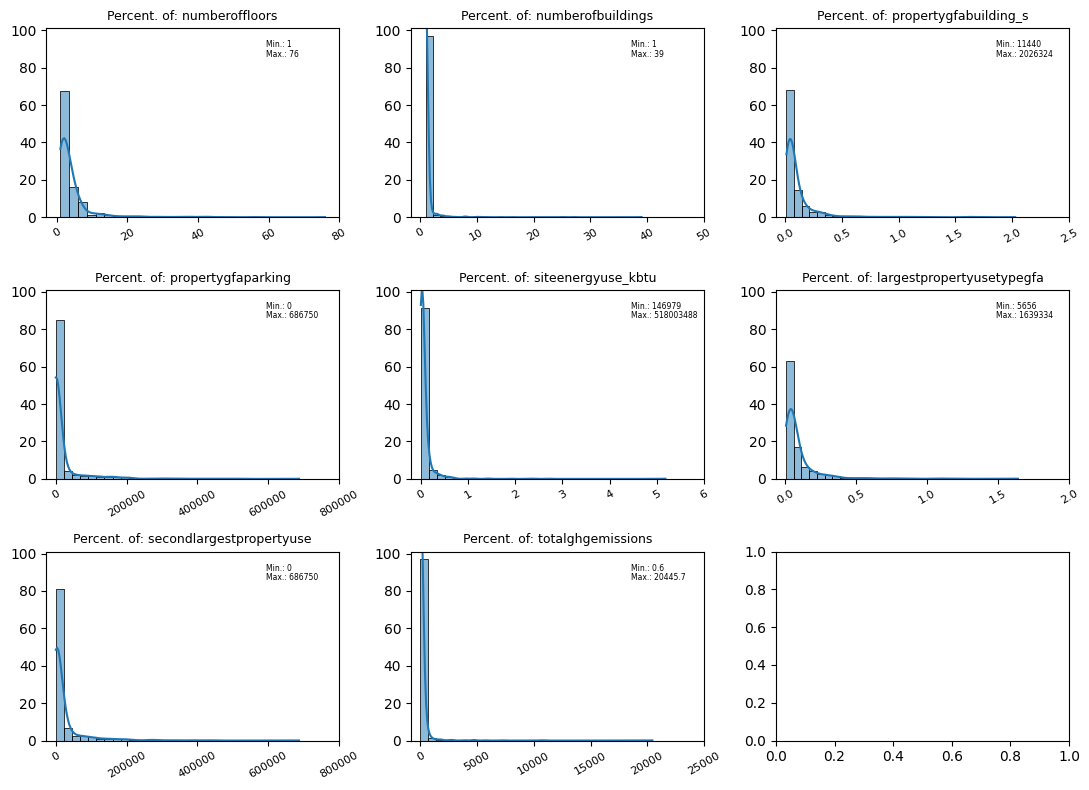

In [109]:
# Representing each variable with a histogram

# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (11,8)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Plot for each column
_, axs = plt.subplots(3, 3)
for i in range(len(quant_cols)):
  sns.histplot(outliers_df, x=quant_cols[i], stat='percent', bins=30, kde=True,
               ax=axs[i//3, i%3])
  # Remove x and y axis names
  axs[i//3, i%3].set(xlabel='', ylabel='')
  # Rotate x-ticks
  axs[i//3, i%3].set_xticks(axs[i//3, i%3].get_xticks(),
                            axs[i//3, i%3].get_xticklabels(),
                            rotation=30, fontsize=8)
  # Set the axis' limits
  axs[i//3, i%3].set_xlim(xmin=-outliers_df[quant_cols[i]].max()*0.04)
  axs[i//3, i%3].set_ylim(ymax=101)
  # Set the column name as title
  axs[i//3, i%3].set_title('Percent. of: {}'.format(quant_cols[i]), fontsize=9)
  # Add min and max within the subplots
  axs[i//3, i%3].text(0.75, 0.9,
                      'Min.: {}'.format(outliers_df[quant_cols[i]].min()),
                      fontsize=5.5, transform=axs[i//3, i%3].transAxes)
  axs[i//3, i%3].text(0.75, 0.85,
                      'Max.: {}'.format(outliers_df[quant_cols[i]].max()),
                      fontsize=5.5, transform=axs[i//3, i%3].transAxes)
# Adjust spacing between (sub)plots
plt.tight_layout()
plt.show()

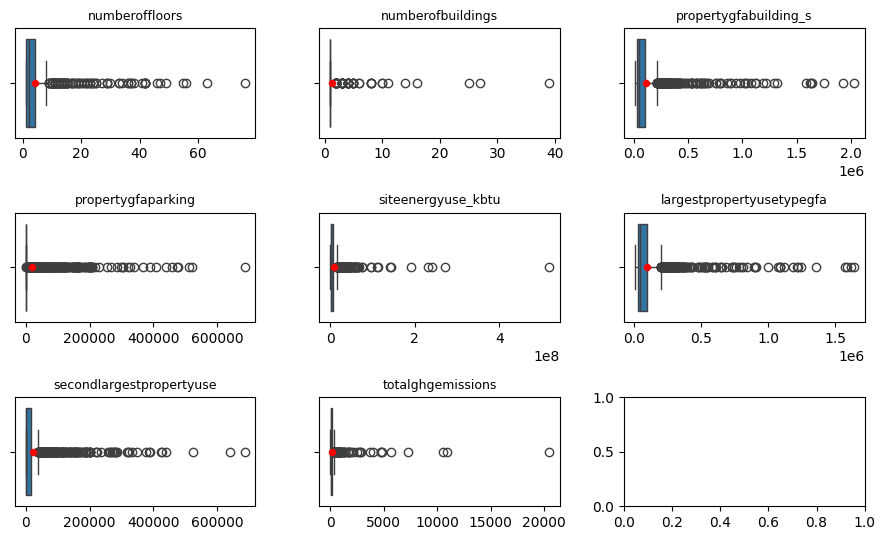

In [110]:
# Let's also represent these variables with a boxplot

# Define the dimensions of the plot (global modification)
plt.rcParams['figure.figsize'] = (9,5.5)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

# Plot for each column
_, axs = plt.subplots(3, 3)
for i in range(len(quant_cols)):
  sns.boxplot(outliers_df, x=quant_cols[i], orient='h', ax=axs[i//3, i%3],
              showmeans=True, meanprops={'marker':'8',
                                         'markerfacecolor':'red',
                                         'markeredgecolor':'red',
                                         'markersize':'5'})
  # Remove x axis name
  axs[i//3, i%3].set(xlabel='')
  # Set the column name as title
  axs[i//3, i%3].set_title(quant_cols[i], fontsize=9)
# Adjust spacing between (sub)plots
plt.tight_layout()
plt.show()

#### Number of floors

In [111]:
# Determine what is the value where we get >5% outliers
col_ = 'numberoffloors'
len_ = len(outliers_df)
v_ = 12

print('Perc. of \'{}\' > {}: {:.2f}%'.format(
    col_, v_, len(outliers_df[outliers_df[col_]>v_])/len_*100))

Perc. of 'numberoffloors' > 12: 5.31%


In [112]:
# Create a column encoding the 'high values' here
outliers_df['high_#floors'] = outliers_df[col_]>v_
outliers_df.head()

,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions,high_#floors
0,Nonresidential COS,98101,47.61623,-122.33657,1,1999,2,1,60090,37198,0,9832419,Police Station,Police Station,50755,Parking,40971,196.0,False
1,NonResidential,98101,47.61327,-122.33136,1,1926,8,1,102761,0,0,7262585,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,102761,None,0,385.9,False
2,Nonresidential COS,98104,47.60649,-122.33297,1,2004,11,1,355000,57000,0,13394116,Library,Library,364913,Parking,49000,108.3,False
3,NonResidential,98104,47.60546,-122.33279,1,1930,6,1,103911,0,0,7162932,Fitness Center/Health Club/Gym,Fitness Center/Health Club/Gym,61528,Office,32195,263.7,False
4,NonResidential,98104,47.60515,-122.33159,1,1907,5,1,57452,0,0,6043709,Mixed Use Property,Social/Meeting Hall,16442,Restaurant,15505,223.8,False


#### Number of buildings

In [113]:
# Determine what is the value where we get >5% outliers
col_ = 'numberofbuildings'
len_ = len(outliers_df)
v_ = 1

print('Perc. of \'{}\' > {}: {:.2f}%'.format(
    col_, v_, len(outliers_df[outliers_df[col_]>v_])/len_*100))

Perc. of 'numberofbuildings' > 1: 5.45%


In [114]:
# Create a column encoding the 'high values' here
outliers_df['moreThan1Building'] = outliers_df[col_]>v_
outliers_df.head()

,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,numberofbuildings,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions,high_#floors,moreThan1Building
0,Nonresidential COS,98101,47.61623,-122.33657,1,1999,2,1,60090,37198,0,9832419,Police Station,Police Station,50755,Parking,40971,196.0,False,False
1,NonResidential,98101,47.61327,-122.33136,1,1926,8,1,102761,0,0,7262585,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,102761,None,0,385.9,False,False
2,Nonresidential COS,98104,47.60649,-122.33297,1,2004,11,1,355000,57000,0,13394116,Library,Library,364913,Parking,49000,108.3,False,False
3,NonResidential,98104,47.60546,-122.33279,1,1930,6,1,103911,0,0,7162932,Fitness Center/Health Club/Gym,Fitness Center/Health Club/Gym,61528,Office,32195,263.7,False,False
4,NonResidential,98104,47.60515,-122.33159,1,1907,5,1,57452,0,0,6043709,Mixed Use Property,Social/Meeting Hall,16442,Restaurant,15505,223.8,False,False


In [115]:
# Finally, drop the 'old' column (this should be enough information as a starter)
outliers_df_1 = outliers_df.drop(columns=col_)
outliers_df_1.head()

,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions,high_#floors,moreThan1Building
0,Nonresidential COS,98101,47.61623,-122.33657,1,1999,2,60090,37198,0,9832419,Police Station,Police Station,50755,Parking,40971,196.0,False,False
1,NonResidential,98101,47.61327,-122.33136,1,1926,8,102761,0,0,7262585,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,102761,None,0,385.9,False,False
2,Nonresidential COS,98104,47.60649,-122.33297,1,2004,11,355000,57000,0,13394116,Library,Library,364913,Parking,49000,108.3,False,False
3,NonResidential,98104,47.60546,-122.33279,1,1930,6,103911,0,0,7162932,Fitness Center/Health Club/Gym,Fitness Center/Health Club/Gym,61528,Office,32195,263.7,False,False
4,NonResidential,98104,47.60515,-122.33159,1,1907,5,57452,0,0,6043709,Mixed Use Property,Social/Meeting Hall,16442,Restaurant,15505,223.8,False,False


#### GFA Building

In [116]:
# Determine what is the value where we get >5% outliers
col_ = 'propertygfabuilding_s'
len_ = len(outliers_df_1)
v_ = 3.5e5

print('Perc. of \'{}\' > {}: {:.2f}%'.format(
    col_, v_, len(outliers_df_1[outliers_df_1[col_]>v_])/len_*100))

Perc. of 'propertygfabuilding_s' > 350000.0: 5.24%


In [117]:
# Determine what is the value where we get >1% outliers
vv_ = 1e6

print('Perc. of \'{}\' > {}: {:.2f}%'.format(
    col_, vv_, len(outliers_df_1[outliers_df_1[col_]>vv_])/len_*100))

Perc. of 'propertygfabuilding_s' > 1000000.0: 1.22%


In [118]:
# Investigate some of these lines (1%)
print('Perc. of high # floors: {:.2f}%'.format(
    len(outliers_df_1[(outliers_df_1[col_]>vv_) & (outliers_df_1['high_#floors'])]
        ) / len(outliers_df_1[outliers_df_1[col_]>vv_]
                )*100))
print('Perc. of more than 1 building: {:.2f}%'.format(
    len(outliers_df_1[(outliers_df_1[col_]>vv_) & (outliers_df_1['moreThan1Building'])]
        ) / len(outliers_df_1[outliers_df_1[col_]>vv_]
                )*100))
#outliers_df_1[(outliers_df_1[col_]>vv_) & (outliers_df_1['high_#floors'])].sample(7, random_state=23)
outliers_df_1[outliers_df_1[col_]>vv_].sample(7, random_state=23)

Perc. of high # floors: 64.71%
Perc. of more than 1 building: 41.18%


,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions,high_#floors,moreThan1Building
12,Campus,98108,47.53493,-122.31788,1,1992,3,2026324,0,0,518003488,Mixed Use Property,Office,686180,Laboratory,639946,20445.7,False,False
451,NonResidential,98104,47.60573,-122.33028,1,1981,42,1047934,201121,85,35049008,Office,Office,999310,Parking,224324,145.0,True,False
100,Campus,98104,47.60399,-122.32377,3,2000,8,1926841,0,85,240119280,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),1355488,Parking,387651,10908.7,False,True
90,NonResidential,98104,47.59544,-122.33159,1,1999,6,1585960,327680,0,59420744,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,1585960,None,0,793.1,False,False
154,Nonresidential COS,98104,47.60501,-122.32988,1,1990,63,1195387,159600,78,43929372,Office,Office,1222878,Parking,275949,184.2,True,False
190,NonResidential,98101,47.60723,-122.33611,7,1988,55,1115000,285000,85,48760400,Office,Office,1119004,Parking,264481,370.7,True,False
489,Campus,98122,47.60884,-122.32193,1,1994,14,1639334,441551,100,190562112,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),1639334,Parking,441551,10541.5,True,True


These appear to be campuses or buildings with numerous floors or buildings.

In [119]:
# Create a column encoding the 'high values' here
outliers_df_1['high_gfaBuilding'] = outliers_df_1[col_]>v_
outliers_df_1.head()

,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions,high_#floors,moreThan1Building,high_gfaBuilding
0,Nonresidential COS,98101,47.61623,-122.33657,1,1999,2,60090,37198,0,9832419,Police Station,Police Station,50755,Parking,40971,196.0,False,False,False
1,NonResidential,98101,47.61327,-122.33136,1,1926,8,102761,0,0,7262585,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,102761,None,0,385.9,False,False,False
2,Nonresidential COS,98104,47.60649,-122.33297,1,2004,11,355000,57000,0,13394116,Library,Library,364913,Parking,49000,108.3,False,False,True
3,NonResidential,98104,47.60546,-122.33279,1,1930,6,103911,0,0,7162932,Fitness Center/Health Club/Gym,Fitness Center/Health Club/Gym,61528,Office,32195,263.7,False,False,False
4,NonResidential,98104,47.60515,-122.33159,1,1907,5,57452,0,0,6043709,Mixed Use Property,Social/Meeting Hall,16442,Restaurant,15505,223.8,False,False,False


#### GFA Parking

In [120]:
# Determine what is the value where we get >5% outliers
col_ = 'propertygfaparking'
len_ = len(outliers_df_1)
v_ = 1.2e5

print('Perc. of \'{}\' > {}: {:.2f}%'.format(
    col_, v_, len(outliers_df_1[outliers_df_1[col_]>v_])/len_*100))

Perc. of 'propertygfaparking' > 120000.0: 5.38%


In [121]:
# Investigate some of these lines
print('Perc. of 2nd Prop. use type being Parking: {:.2f}%'.format(
    len(outliers_df_1[(outliers_df_1[col_]>v_) & (outliers_df_1['secondlargestpropertyusetype']=='Parking')]
        ) / len(outliers_df_1[outliers_df_1[col_]>v_]
                )*100))
outliers_df_1[outliers_df_1[col_]>v_].sample(7, random_state=23)

Perc. of 2nd Prop. use type being Parking: 90.67%


,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions,high_#floors,moreThan1Building,high_gfaBuilding
372,NonResidential,98101,47.60740,-122.33777,1,2005,42,1295457,297457,94,39360156,Office,Office,901624,Parking,348788,265.6,True,False,True
483,NonResidential,98104,47.60214,-122.32726,3,2009,17,275166,138098,91,9890051,Office,Office,303400,Parking,94872,40.9,True,False,False
211,NonResidential,98121,47.61170,-122.34778,1,1998,11,189629,184776,62,13048167,Office,Office,175663,Laboratory,17135,54.0,False,False,False
136,NonResidential,98101,47.61555,-122.33582,1,2009,36,669915,154972,81,32910994,Office,Office,743562,Parking,161119,143.3,True,False,True
379,NonResidential,98104,47.60883,-122.32494,1,1973,19,163504,156407,78,17151908,Medical Office,Medical Office,170727,Parking,69171,545.0,True,False,False
1390,Campus,98121,47.61695,-122.33991,1,2019,24,983399,340374,94,34095340,Office,Office,841567,Parking,322626,432.2,True,True,True
1323,NonResidential,98109,47.62906,-122.34259,1,2015,10,345992,167824,91,15340774,Office,Office,360127,Parking,151658,101.5,False,False,False


That makes sense, and I expect some correlations so I'm not creating an encoding column.

#### SiteEnergy

In [122]:
# Determine what is the value where we get >5% outliers
col_ = 'siteenergyuse_kbtu'
len_ = len(outliers_df_1)
v_ = 2.9e7

print('Perc. of \'{}\' > {}: {:.2f}%'.format(
    col_, v_, len(outliers_df_1[outliers_df_1[col_]>v_])/len_*100))

Perc. of 'siteenergyuse_kbtu' > 29000000.0: 5.16%


In [123]:
# Create a column encoding the 'high values' here
outliers_df_1['high_energyUse'] = outliers_df_1[col_]>v_
outliers_df_1.head()

,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions,high_#floors,moreThan1Building,high_gfaBuilding,high_energyUse
0,Nonresidential COS,98101,47.61623,-122.33657,1,1999,2,60090,37198,0,9832419,Police Station,Police Station,50755,Parking,40971,196.0,False,False,False,False
1,NonResidential,98101,47.61327,-122.33136,1,1926,8,102761,0,0,7262585,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,102761,None,0,385.9,False,False,False,False
2,Nonresidential COS,98104,47.60649,-122.33297,1,2004,11,355000,57000,0,13394116,Library,Library,364913,Parking,49000,108.3,False,False,True,False
3,NonResidential,98104,47.60546,-122.33279,1,1930,6,103911,0,0,7162932,Fitness Center/Health Club/Gym,Fitness Center/Health Club/Gym,61528,Office,32195,263.7,False,False,False,False
4,NonResidential,98104,47.60515,-122.33159,1,1907,5,57452,0,0,6043709,Mixed Use Property,Social/Meeting Hall,16442,Restaurant,15505,223.8,False,False,False,False


#### Largest Prop. GFA

In [124]:
# Determine what is the value where we get >5% outliers
col_ = 'largestpropertyusetypegfa'
len_ = len(outliers_df_1)
v_ = 3.4e5

print('Perc. of \'{}\' > {}: {:.2f}%'.format(
    col_, v_, len(outliers_df_1[outliers_df_1[col_]>v_])/len_*100))

Perc. of 'largestpropertyusetypegfa' > 340000.0: 5.02%


In [125]:
# Investigate some of these lines
print('Perc. of 2nd Prop. use type being Parking: {:.2f}%'.format(
    len(outliers_df_1[(outliers_df_1[col_]>v_) & (outliers_df_1['high_gfaBuilding'])]
        ) / len(outliers_df_1[outliers_df_1[col_]>v_]
                )*100))
outliers_df_1[outliers_df_1[col_]>v_].sample(7, random_state=23)

Perc. of 2nd Prop. use type being Parking: 94.29%


,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions,high_#floors,moreThan1Building,high_gfaBuilding,high_energyUse
90,NonResidential,98104,47.59544,-122.33159,1,1999,6,1585960,327680,0,59420744,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,1585960,None,0,793.1,False,False,True,True
389,NonResidential,98101,47.61150,-122.33278,1,2001,23,609972,84660,96,14751269,Office,Office,586307,Parking,108325,61.0,True,False,True,False
136,NonResidential,98101,47.61555,-122.33582,1,2009,36,669915,154972,81,32910994,Office,Office,743562,Parking,161119,143.3,True,False,True,True
458,NonResidential,98104,47.59878,-122.33088,1,1998,8,321473,124788,94,11714038,Office,Office,343400,Parking,114237,48.5,False,False,False,False
150,NonResidential,98104,47.60615,-122.33388,1,1969,49,754455,368980,80,39338768,Office,Office,907746,Parking,234689,406.6,True,False,True,True
144,NonResidential,98104,47.60567,-122.33511,7,1986,41,460489,129432,88,17007542,Office,Office,479650,Parking,139555,70.4,True,False,True,False
78,SPS-District K-12,98106,47.52915,-122.36511,1,2010,2,372897,0,74,16180345,K-12 School,K-12 School,372897,None,0,515.9,False,False,True,False


In [126]:
# Since the "information" is already in the 2nd Prop. use type somehow,
# I don't create a new column here.

# Create a column encoding the 'high values' here
#outliers_df_1['high_largGfa'] = outliers_df_1[col_]>v_
#outliers_df_1.head()

#### 2nd Largest Prop. GFA

In [127]:
# Determine what is the value where we get >5% outliers
col_ = 'secondlargestpropertyuse'
len_ = len(outliers_df_1)
v_ = 1.2e5

print('Perc. of \'{}\' > {}: {:.2f}%'.format(
    col_, v_, len(outliers_df_1[outliers_df_1[col_]>v_])/len_*100))

Perc. of 'secondlargestpropertyuse' > 120000.0: 5.24%


In [128]:
# Investigate some of these lines
print('Perc. of 2nd Prop. use type being Parking: {:.2f}%'.format(
    len(outliers_df_1[(outliers_df_1[col_]>v_) & (outliers_df_1['secondlargestpropertyusetype']=='Parking')]
        ) / len(outliers_df_1[outliers_df_1[col_]>v_]
                )*100))
outliers_df_1[outliers_df_1[col_]>v_].sample(7, random_state=23)

Perc. of 2nd Prop. use type being Parking: 89.04%


,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions,high_#floors,moreThan1Building,high_gfaBuilding,high_energyUse
151,NonResidential,98104,47.60549,-122.33319,7,2002,37,888049,164420,90,31351304,Office,Office,779235,Parking,185581,129.7,True,False,True,True
1349,NonResidential,98109,47.62231,-122.34194,1,2017,12,293826,149292,27,44739164,Office,Office,290117,Parking,160537,1129.7,False,False,False,True
861,Campus,98112,47.62014,-122.31228,3,1964,3,674282,208000,0,110285840,Medical Office,Medical Office,520187,Parking,282392,3750.0,False,True,True,True
127,NonResidential,98101,47.61229,-122.33629,1,1925,10,693450,0,89,34799348,Retail Store,Retail Store,361107,Office,332343,228.9,False,False,True,True
300,NonResidential,98109,47.62029,-122.33078,1,2005,6,211900,124800,80,10182272,Office,Office,215402,Parking,124620,42.1,False,False,False,False
191,NonResidential,98101,47.61054,-122.33466,1,1989,46,1023998,512608,84,41546432,Office,Office,1089012,Parking,377046,171.9,True,False,True,True
1319,NonResidential,98109,47.62384,-122.33941,1,2014,6,414200,179000,94,14477637,Office,Office,427181,Parking,169195,127.7,False,False,True,False


As for GFA Parking, that makes sense, and I expect some correlations so I'm not creating an encoding column.

#### Total GHGEmissions

In [129]:
# Determine what is the value where we get >5% outliers
col_ = 'totalghgemissions'
len_ = len(outliers_df_1)
v_ = 500

print('Perc. of \'{}\' > {}: {:.2f}%'.format(
    col_, v_, len(outliers_df_1[outliers_df_1[col_]>v_])/len_*100))

Perc. of 'totalghgemissions' > 500: 5.38%


In [130]:
# Investigate some of these lines
outliers_df_1[outliers_df_1[col_]>v_].sample(7, random_state=23)

,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions,high_#floors,moreThan1Building,high_gfaBuilding,high_energyUse
331,NonResidential,98102,47.63108,-122.32746,1,1920,3,106003,63782,0,32944680,Office,Office,63602,Laboratory,42401,1044.0,False,False,False,True
707,NonResidential,98122,47.60874,-122.32024,1,1988,5,34380,11400,0,11763937,Laboratory,Laboratory,45780,None,0,552.3,False,False,False,False
239,NonResidential,98101,47.60953,-122.32793,1,1975,8,252055,0,3,38739508,Medical Office,Medical Office,252055,None,0,1171.9,False,False,False,True
90,NonResidential,98104,47.59544,-122.33159,1,1999,6,1585960,327680,0,59420744,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,1585960,None,0,793.1,False,False,True,True
379,NonResidential,98104,47.60883,-122.32494,1,1973,19,163504,156407,78,17151908,Medical Office,Medical Office,170727,Parking,69171,545.0,True,False,False,False
1363,Campus,98119,47.63100,-122.38282,1,2000,4,1012278,0,0,55399684,Mixed Use Property,Manufacturing/Industrial Plant,379314,Refrigerated Warehouse,287748,574.1,False,True,True,True
1280,Nonresidential COS,98122,47.60668,-122.30242,3,1968,1,21400,0,0,13455022,Other - Recreation,Other - Recreation,11737,Fitness Center/Health Club/Gym,9003,649.1,False,False,False,False


In [131]:
# Create a column encoding the 'high values' here
outliers_df_1['high_GHGE'] = outliers_df_1[col_]>v_
outliers_df_1.head()

,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions,high_#floors,moreThan1Building,high_gfaBuilding,high_energyUse,high_GHGE
0,Nonresidential COS,98101,47.61623,-122.33657,1,1999,2,60090,37198,0,9832419,Police Station,Police Station,50755,Parking,40971,196.0,False,False,False,False,False
1,NonResidential,98101,47.61327,-122.33136,1,1926,8,102761,0,0,7262585,Other - Entertainment/Public Assembly,Other - Entertainment/Public Assembly,102761,None,0,385.9,False,False,False,False,False
2,Nonresidential COS,98104,47.60649,-122.33297,1,2004,11,355000,57000,0,13394116,Library,Library,364913,Parking,49000,108.3,False,False,True,False,False
3,NonResidential,98104,47.60546,-122.33279,1,1930,6,103911,0,0,7162932,Fitness Center/Health Club/Gym,Fitness Center/Health Club/Gym,61528,Office,32195,263.7,False,False,False,False,False
4,NonResidential,98104,47.60515,-122.33159,1,1907,5,57452,0,0,6043709,Mixed Use Property,Social/Meeting Hall,16442,Restaurant,15505,223.8,False,False,False,False,False


### 3.2.2. Qualitative variables

In [132]:
# Set the dimensions of the plots (global modification)
plt.rcParams['figure.figsize'] = (9,4.5)
# To reset figsize for future plots
#plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

#### Building Type

In [133]:
# Define the column
col_ = 'buildingtype'

# Start by checking the number of modalities
mods_ = len(outliers_df_1[col_].unique())
print(f'There are {mods_} different modalities for the column {col_}')

There are 5 different modalities for the column buildingtype


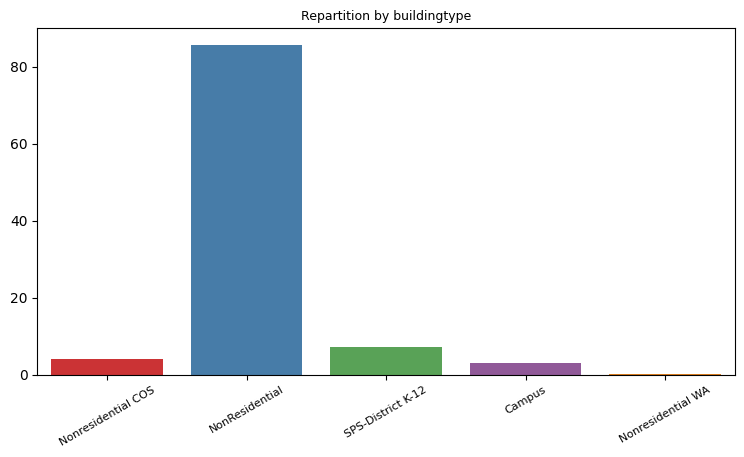

In [134]:
# Plot them
ax = sns.countplot(outliers_df_1, x=col_, hue=col_, palette='Set1',
                   stat='percent', legend=False)
# Remove x and y axis names
ax.set(xlabel='', ylabel='')
# Rotate x-ticks
ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(), rotation=30, fontsize=8)
# Set the title
ax.set_title('Repartition by {}'.format(col_), fontsize=9)
plt.show()

#### ZipCode

In [135]:
# Define the column
col_ = 'zipcode'

# Start by checking the number of modalities
mods_ = len(outliers_df_1[col_].unique())
print(f'There are {mods_} different modalities for the column {col_}')

There are 29 different modalities for the column zipcode


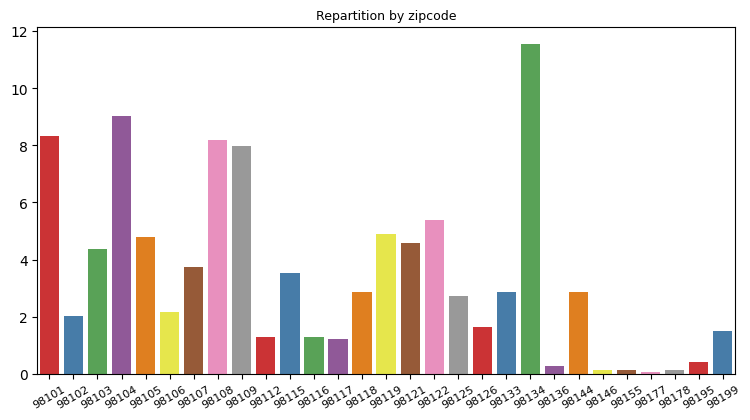

In [136]:
# Plot them (starts to be a bit messy)
ax = sns.countplot(outliers_df_1, x=col_, hue=col_, palette='Set1',
                   stat='percent', legend=False)
# Remove x and y axis names
ax.set(xlabel='', ylabel='')
# Rotate x-ticks
ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(), rotation=30, fontsize=8)
# Set the title
ax.set_title('Repartition by {}'.format(col_), fontsize=9)
plt.show()

#### Council District Code

In [137]:
# Define the column
col_ = 'councildistrictcode'

# Start by checking the number of modalities
mods_ = len(outliers_df_1[col_].unique())
print(f'There are {mods_} different modalities for the column {col_}')

There are 7 different modalities for the column councildistrictcode


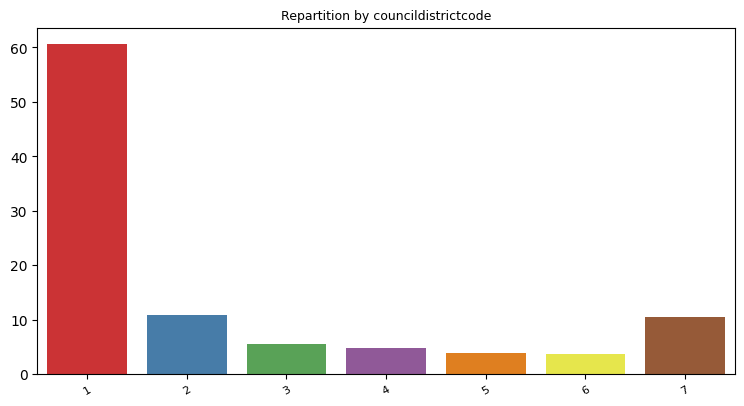

In [138]:
# Plot them
ax = sns.countplot(outliers_df_1, x=col_, hue=col_, palette='Set1',
                   stat='percent', legend=False)
# Remove x and y axis names
ax.set(xlabel='', ylabel='')
# Rotate x-ticks
ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(), rotation=30, fontsize=8)
# Set the title
ax.set_title('Repartition by {}'.format(col_), fontsize=9)
plt.show()

#### Year Built

In [139]:
# Define the column
col_ = 'yearbuilt'

# Start by checking the number of modalities
mods_ = len(outliers_df_1[col_].unique())
print(f'There are {mods_} different modalities for the column {col_}')

There are 117 different modalities for the column yearbuilt


That's too many to plot, and I already checked the min and the max [here](#scrollTo=5EZbICXuy05r).

#### EPA Property Type

In [140]:
# Define the column
col_ = 'epapropertytype'

# Start by checking the number of modalities
mods_ = len(outliers_df_1[col_].unique())
print(f'There are {mods_} different modalities for the column {col_}')

There are 54 different modalities for the column epapropertytype


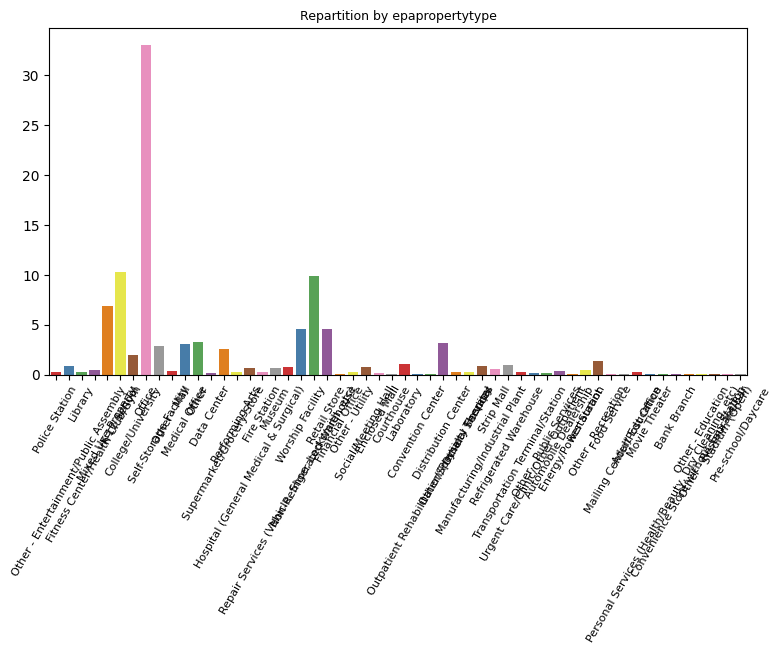

In [141]:
# Plot them (that will be messy but I want to check for a "peak", if any)
ax = sns.countplot(outliers_df_1, x=col_, hue=col_, palette='Set1',
                   stat='percent', legend=False)
# Remove x and y axis names
ax.set(xlabel='', ylabel='')
# Rotate x-ticks
ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(), rotation=60, fontsize=8)
# Set the title
ax.set_title('Repartition by {}'.format(col_), fontsize=9)
plt.show()

In [142]:
# Perc. of "Office" versus the total (just to confirm)
len(outliers_df_1[outliers_df_1[col_]=='Office'])/len(outliers_df_1)*100

33.07030129124821

#### Largest Property Use Type

In [143]:
# Define the column
col_ = 'largestpropertyusetype'

# Start by checking the number of modalities
mods_ = len(outliers_df_1[col_].unique())
print(f'There are {mods_} different modalities for the column {col_}')

There are 53 different modalities for the column largestpropertyusetype


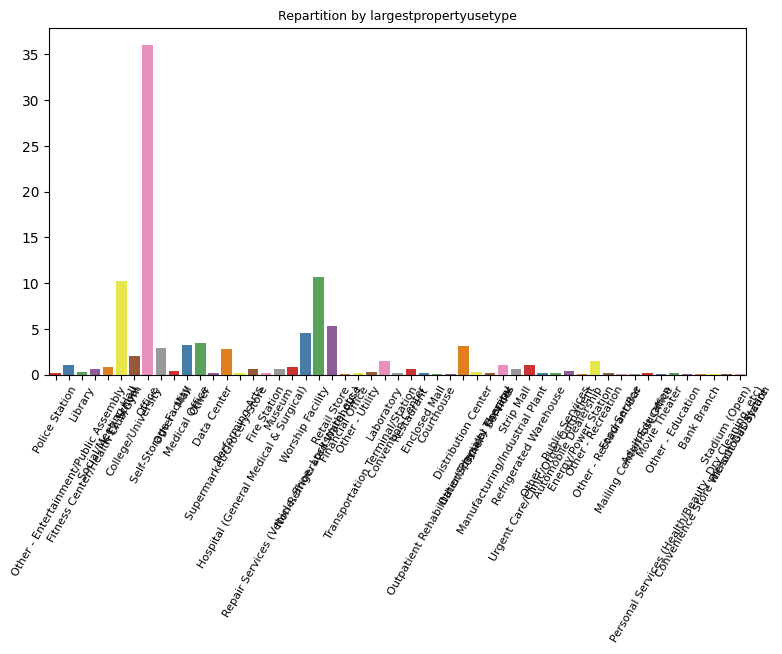

In [144]:
# Plot them (that will be messy but I want to check for a "peak", if any)
ax = sns.countplot(outliers_df_1, x=col_, hue=col_, palette='Set1',
                   stat='percent', legend=False)
# Remove x and y axis names
ax.set(xlabel='', ylabel='')
# Rotate x-ticks
ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(), rotation=60, fontsize=8)
# Set the title
ax.set_title('Repartition by {}'.format(col_), fontsize=9)
plt.show()

In [145]:
# Quick check on the difference between epapropertytype and largestpropertyusetype
col_epa = 'epapropertytype'
col_larg = 'largestpropertyusetype'
sum(outliers_df_1[col_epa] != outliers_df_1[col_larg])

106

In [146]:
# Show some of the rows where it is different
outliers_df_1[outliers_df_1[col_epa] != outliers_df_1[col_larg]].sample(
    7, random_state=23)

,buildingtype,zipcode,latitude,longitude,councildistrictcode,yearbuilt,numberoffloors,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,epapropertytype,largestpropertyusetype,largestpropertyusetypegfa,secondlargestpropertyusetype,secondlargestpropertyuse,totalghgemissions,high_#floors,moreThan1Building,high_gfaBuilding,high_energyUse,high_GHGE
953,NonResidential,98134,47.57019,-122.32352,1,1954,1,35222,0,0,1009388,"Repair Services (Vehicle, Shoe, Locksmith, etc)","Repair Services (Vehicle, Shoe, Locksmith, etc.)",23380,Retail Store,6652,12.9,False,False,False,False,False
694,NonResidential,98109,47.62231,-122.34145,7,1928,2,28800,0,0,346018,Mixed Use Property,Non-Refrigerated Warehouse,14400,Office,14400,11.6,False,False,False,False,False
597,NonResidential,98116,47.56147,-122.38638,1,1930,2,20700,0,0,4950972,Mixed Use Property,Non-Refrigerated Warehouse,6900,Restaurant,6900,226.7,False,False,False,False,False
1274,NonResidential,98102,47.62256,-122.32150,1,1916,2,81422,59401,0,2910937,Mixed Use Property,Supermarket/Grocery Store,64000,Parking,59401,25.9,False,False,False,False,False
1156,Nonresidential COS,98104,47.59986,-122.33195,1,1929,4,48381,6316,0,4896555,Mixed Use Property,Office,22565,Fire Station,19645,160.5,False,False,False,False,False
1144,NonResidential,98103,47.64748,-122.33435,1,1979,2,78716,0,0,3729863,Mixed Use Property,Office,38511,Non-Refrigerated Warehouse,33927,35.0,False,False,False,False,False
1138,NonResidential,98134,47.56555,-122.33362,2,1947,1,30496,0,0,2032731,Mixed Use Property,Retail Store,14344,Manufacturing/Industrial Plant,10272,40.3,False,False,False,False,False


In [147]:
# They seem to carry the same information, so I'll drop this one
outliers_df_2 = outliers_df_1.drop(columns=col_larg)

#### 2nd Largest Property Use Type

In [148]:
# Define the column
col_ = 'secondlargestpropertyusetype'

# Start by checking the number of modalities
mods_ = len(outliers_df_2[col_].unique())
print(f'There are {mods_} different modalities for the column {col_}')

There are 44 different modalities for the column secondlargestpropertyusetype


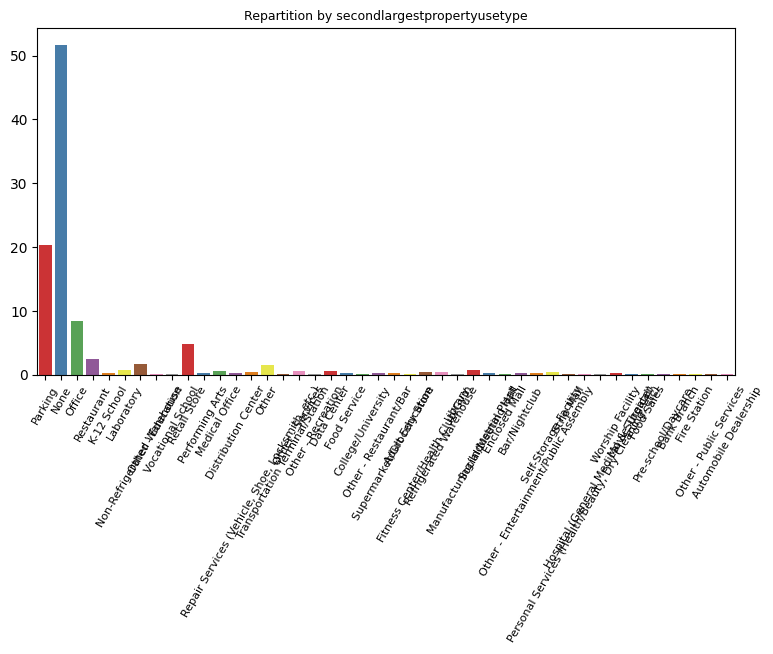

In [149]:
# Plot them (that will be messy but I want to check for a "peak", if any)
ax = sns.countplot(outliers_df_2, x=col_, hue=col_, palette='Set1',
                   stat='percent', legend=False)
# Remove x and y axis names
ax.set(xlabel='', ylabel='')
# Rotate x-ticks
ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(), rotation=60, fontsize=8)
# Set the title
ax.set_title('Repartition by {}'.format(col_), fontsize=9)
plt.show()

## 3.3. Missing values

In [150]:
# Let's make a copy here
miss_df = outliers_df_2.copy()

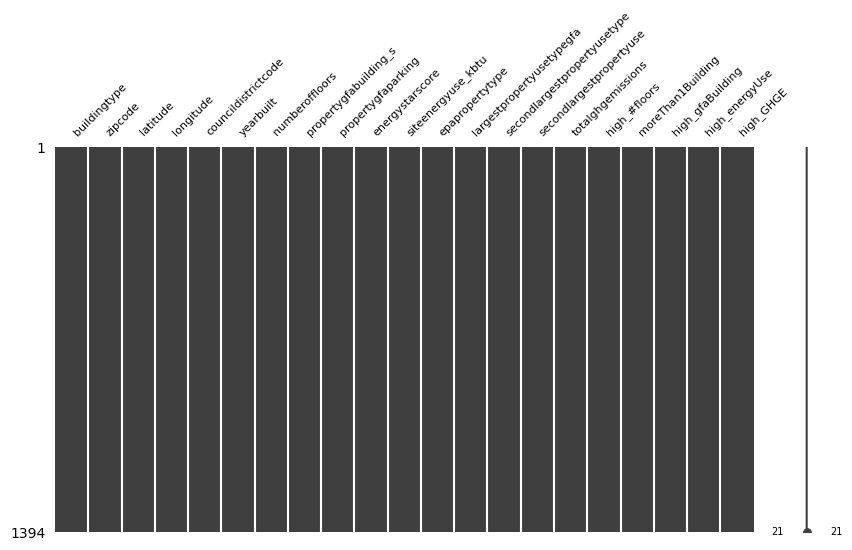

In [151]:
# Let's have an idea of the completion, visually
import missingno as msno

_ = msno.matrix(df=miss_df, figsize=(10,5), fontsize=8)

## 3.4. Encoding

I will now encode my qualitative variables. I can use:
- OrdinalEncoder for hierarchichal values,
- OneHotEncoder for the others.

Since no variable contains any hierarchy, I will only use [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). A big con is that is will generate a lot of new columns for the high number of different modalities.

An alternative to this module could be [the one from Category Encoders](https://contrib.scikit-learn.org/category_encoders/onehot.html) which has some additional features, not needed here.

In [152]:
# Start by creating a copy
encod_df = miss_df.copy()
encod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1394 entries, 0 to 1393
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   buildingtype                  1394 non-null   object 
 1   zipcode                       1394 non-null   int64  
 2   latitude                      1394 non-null   float64
 3   longitude                     1394 non-null   float64
 4   councildistrictcode           1394 non-null   int64  
 5   yearbuilt                     1394 non-null   int64  
 6   numberoffloors                1394 non-null   int64  
 7   propertygfabuilding_s         1394 non-null   int64  
 8   propertygfaparking            1394 non-null   int64  
 9   energystarscore               1394 non-null   int64  
 10  siteenergyuse_kbtu            1394 non-null   int64  
 11  epapropertytype               1394 non-null   object 
 12  largestpropertyusetypegfa     1394 non-null   int64  
 13  sec

In [153]:
# Instantiate the encoder
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

# Define the columns to encode
cols_encode = ['buildingtype', 'zipcode', 'councildistrictcode',
               'epapropertytype', 'secondlargestpropertyusetype']

In [154]:
# Apply OneHotEncoder to the columns - returns a sparse matrix (2D NumPy array)
ohe_arr = ohe.fit_transform(encod_df[cols_encode])

In [155]:
# Get feature names
feature_names = ohe.get_feature_names_out(cols_encode)

# Create a DataFrame from the encoded columns
encoded_df = pd.DataFrame(ohe_arr.toarray(), columns=feature_names)

In [156]:
# Concatenate the original DataFrame with the encoded DataFrame
# while dropping original columns as they are now encoded
df_encoded = pd.concat([encod_df.drop(columns=cols_encode), encoded_df], axis=1)
df_encoded.shape

(1394, 155)

In [157]:
df_encoded.head()

,latitude,longitude,yearbuilt,numberoffloors,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,largestpropertyusetypegfa,secondlargestpropertyuse,totalghgemissions,high_#floors,moreThan1Building,high_gfaBuilding,high_energyUse,high_GHGE,buildingtype_Campus,buildingtype_NonResidential,buildingtype_Nonresidential COS,buildingtype_Nonresidential WA,buildingtype_SPS-District K-12,...,secondlargestpropertyusetype_Other - Education,secondlargestpropertyusetype_Other - Entertainment/Public Assembly,secondlargestpropertyusetype_Other - Public Services,secondlargestpropertyusetype_Other - Recreation,secondlargestpropertyusetype_Other - Restaurant/Bar,secondlargestpropertyusetype_Other - Services,secondlargestpropertyusetype_Parking,secondlargestpropertyusetype_Performing Arts,"secondlargestpropertyusetype_Personal Services (Health/Beauty, Dry Cleaning, etc)",secondlargestpropertyusetype_Pre-school/Daycare,secondlargestpropertyusetype_Refrigerated Warehouse,"secondlargestpropertyusetype_Repair Services (Vehicle, Shoe, Locksmith, etc.)",secondlargestpropertyusetype_Restaurant,secondlargestpropertyusetype_Retail Store,secondlargestpropertyusetype_Self-Storage Facility,secondlargestpropertyusetype_Social/Meeting Hall,secondlargestpropertyusetype_Strip Mall,secondlargestpropertyusetype_Supermarket/Grocery Store,secondlargestpropertyusetype_Transportation Terminal/Station,secondlargestpropertyusetype_Vocational School,secondlargestpropertyusetype_Worship Facility
0,47.61623,-122.33657,1999,2,60090,37198,0,9832419,50755,40971,196.0,False,False,False,False,False,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,47.61327,-122.33136,1926,8,102761,0,0,7262585,102761,0,385.9,False,False,False,False,False,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,47.60649,-122.33297,2004,11,355000,57000,0,13394116,364913,49000,108.3,False,False,True,False,False,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,47.60546,-122.33279,1930,6,103911,0,0,7162932,61528,32195,263.7,False,False,False,False,False,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,47.60515,-122.33159,1907,5,57452,0,0,6043709,16442,15505,223.8,False,False,False,False,False,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3.5. Scaling

### Features

Using [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to scale each feature to be between 0 and 1.

In [158]:
# Start by making a copy
scale_df = df_encoded.copy()

In [159]:
scale_df.head()

,latitude,longitude,yearbuilt,numberoffloors,propertygfabuilding_s,propertygfaparking,energystarscore,siteenergyuse_kbtu,largestpropertyusetypegfa,secondlargestpropertyuse,totalghgemissions,high_#floors,moreThan1Building,high_gfaBuilding,high_energyUse,high_GHGE,buildingtype_Campus,buildingtype_NonResidential,buildingtype_Nonresidential COS,buildingtype_Nonresidential WA,buildingtype_SPS-District K-12,...,secondlargestpropertyusetype_Other - Education,secondlargestpropertyusetype_Other - Entertainment/Public Assembly,secondlargestpropertyusetype_Other - Public Services,secondlargestpropertyusetype_Other - Recreation,secondlargestpropertyusetype_Other - Restaurant/Bar,secondlargestpropertyusetype_Other - Services,secondlargestpropertyusetype_Parking,secondlargestpropertyusetype_Performing Arts,"secondlargestpropertyusetype_Personal Services (Health/Beauty, Dry Cleaning, etc)",secondlargestpropertyusetype_Pre-school/Daycare,secondlargestpropertyusetype_Refrigerated Warehouse,"secondlargestpropertyusetype_Repair Services (Vehicle, Shoe, Locksmith, etc.)",secondlargestpropertyusetype_Restaurant,secondlargestpropertyusetype_Retail Store,secondlargestpropertyusetype_Self-Storage Facility,secondlargestpropertyusetype_Social/Meeting Hall,secondlargestpropertyusetype_Strip Mall,secondlargestpropertyusetype_Supermarket/Grocery Store,secondlargestpropertyusetype_Transportation Terminal/Station,secondlargestpropertyusetype_Vocational School,secondlargestpropertyusetype_Worship Facility
0,47.61623,-122.33657,1999,2,60090,37198,0,9832419,50755,40971,196.0,False,False,False,False,False,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,47.61327,-122.33136,1926,8,102761,0,0,7262585,102761,0,385.9,False,False,False,False,False,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,47.60649,-122.33297,2004,11,355000,57000,0,13394116,364913,49000,108.3,False,False,True,False,False,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,47.60546,-122.33279,1930,6,103911,0,0,7162932,61528,32195,263.7,False,False,False,False,False,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,47.60515,-122.33159,1907,5,57452,0,0,6043709,16442,15505,223.8,False,False,False,False,False,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
# Instantiate the scaler
from sklearn.preprocessing import MinMaxScaler

scaler_feat = MinMaxScaler()

# Define the columns to scale
cols_scale = ['latitude', 'longitude', 'yearbuilt', 'numberoffloors',
              'propertygfabuilding_s', 'propertygfaparking', 'energystarscore',
              'siteenergyuse_kbtu', 'largestpropertyusetypegfa',
              'secondlargestpropertyuse', 'totalghgemissions']

In [161]:
# Create a DataFrame from the scaled columns
scaled_df = pd.DataFrame(scaler_feat.fit_transform(scale_df[cols_scale]),
                         columns=cols_scale)

In [162]:
# Concatenate the original DataFrame with the encoded DataFrame
# while dropping original columns as they are now encoded
df_scaled = pd.concat([scale_df.drop(columns=cols_scale), scaled_df], axis=1)
df_scaled.shape

(1394, 155)

In [163]:
# Make sure that the target columns and EnergyStarScore are at the end
cols_to_move = ['energystarscore', 'siteenergyuse_kbtu', 'totalghgemissions']
df_scaled = df_scaled[
    [c for c in df_scaled if c not in cols_to_move] + cols_to_move]

## 3.6. Correlations

In [164]:
# Plotly docs:
# https://plotly.com/python-api-reference/generated/plotly.express.imshow.html
# https://plotly.com/python/imshow/

import plotly.express as px

# Assume df is your DataFrame
fig = px.imshow(df_scaled.corr(), color_continuous_scale='RdBu_r',
                width=900, height=900)
# Remove x and y -axes labels
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
# Set the title
fig.update_layout(title_text='Correlation Heatmap', title_x=0.5)
fig.show()

# 4. Prediction

Using [one of these scores](https://scikit-learn.org/stable/modules/model_evaluation.html) for the model evaluation, here the RMSE.

The models tested are:
- [Dummy Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html)
- [Ridge Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
- [kNN Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)
- [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- [XGBoost](https://xgboost.readthedocs.io/en/latest/parameter.html)


In [165]:
df_scaled.columns

Index(['high_#floors', 'moreThan1Building', 'high_gfaBuilding',
       'high_energyUse', 'high_GHGE', 'buildingtype_Campus',
       'buildingtype_NonResidential', 'buildingtype_Nonresidential COS',
       'buildingtype_Nonresidential WA', 'buildingtype_SPS-District K-12',
       ...
       'longitude', 'yearbuilt', 'numberoffloors', 'propertygfabuilding_s',
       'propertygfaparking', 'largestpropertyusetypegfa',
       'secondlargestpropertyuse', 'energystarscore', 'siteenergyuse_kbtu',
       'totalghgemissions'],
      dtype='object', length=155)

In [166]:
# Define the data and the targets
X_wo_starscore = df_scaled[df_scaled.columns[:-3]].values
X_w_starscore = df_scaled[df_scaled.columns[:-2]].values
y_en = df_scaled['siteenergyuse_kbtu'].values
y_em = df_scaled['totalghgemissions'].values

In [167]:
# Import the different models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
# If this throws an error, install XGBoost:
#!pip install xgboost
from xgboost import XGBRegressor

# Used to evaluate the performances
import numpy as np
from sklearn import metrics
import scipy as sp

# For execution time
import time

In [168]:
# Define a function to get results for the models
def perf_model(X_train, X_test, y_train, y_test, regr):
  start_ = time.time()

  # Fit
  regr.fit(X_train, y_train)

  # Predict
  y_pred = regr.predict(X_test)

  # Calculate the error
  RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
  end_ = time.time()

  # Calculate the execution time
  elapsed = end_ - start_

  return RMSE, elapsed

In [ ]:
# Define the score to optimize for GridSearchCV and RandomizedSearchCV
score = 'neg_root_mean_squared_error'

## 4.1. CO2 emissions

In [169]:
# Prepare the data using train_test_split
from sklearn import model_selection

X_em_train, X_em_test, y_em_train, y_em_test = model_selection.train_test_split(
    X_w_starscore, y_em, test_size=0.25, random_state=23)

In [170]:
# Initialize lists to store the results
em_rmse = []
em_elapsed = []

### 4.1.1. Dummy Regressor

In [171]:
# Define the regressor
dum = DummyRegressor(strategy='mean')

# Call the function
RMSE_dum_em, elapsed_dum_em = perf_model(X_em_train, X_em_test,
                                         y_em_train, y_em_test,
                                         dum)

# Display and store the results
print(f'RMSE: {RMSE_dum_em:.2f}')
em_rmse.append(RMSE_dum_em)
print(f'Execution time: {elapsed_dum_em:.2f}')
em_elapsed.append(elapsed_dum_em)

RMSE: 0.02
Execution time: 0.00


### 4.1.2. Ridge Regressor

In [172]:
%%time
# Start by looking for the best hyperparameters for the model

# Define the hyperparameters to look for
# 'lbfgs' not included because throws error
param_grid = {
    'solver':['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

# Define the regressor with hyperparameter lookup using cross validation
rr = model_selection.GridSearchCV(Ridge(random_state=23),
                                  param_grid=param_grid, scoring=score,
                                  n_jobs=-1, cv=5, verbose=5)

# Fit
rr.fit(X_em_train, y_em_train)

# Best model
print(f'Best model on training data: {rr.best_estimator_}')
# Best score
print(f'Best score on training data: {rr.best_score_}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best model on training data: Ridge(random_state=23, solver='lsqr')
Best score on training data: -0.03209819228146949
CPU times: user 1.34 s, sys: 125 ms, total: 1.46 s
Wall time: 7.68 s


In [173]:
# Call the function using the best model
RMSE_rr_em, elapsed_rr_em = perf_model(X_em_train, X_em_test,
                                       y_em_train, y_em_test,
                                       rr.best_estimator_)

# Display and store the results
print(f'RMSE: {RMSE_rr_em:.2f}')
em_rmse.append(RMSE_rr_em)
print(f'Execution time: {elapsed_rr_em:.2f}')
em_elapsed.append(elapsed_rr_em)

RMSE: 0.02
Execution time: 0.04


### 4.1.3. kNN Regressor

In [174]:
%%time
# Start by looking for the best hyperparameters for the model

# Define the hyperparameters to look for
param_dist = {'n_neighbors':sp.stats.randint(3, 20),
              'weights':['uniform', 'distance'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'leaf_size':sp.stats.randint(10, 50)}

# Define the regressor with hyperparameter lookup using cross validation
knnR = model_selection.RandomizedSearchCV(KNeighborsRegressor(),
                                          param_distributions=param_dist,
                                          scoring=score, n_jobs=-1, cv=5,
                                          verbose=5, random_state=23)

# Fit
knnR.fit(X_em_train, y_em_train)

# Best model
print(f'Best model on training data: {knnR.best_estimator_}')
# Best score
print(f'Best score on training data: {knnR.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best model on training data: KNeighborsRegressor(algorithm='brute', leaf_size=19, n_neighbors=11,
                    weights='distance')
Best score on training data: -0.03126073224575364
CPU times: user 1.22 s, sys: 26.4 ms, total: 1.25 s
Wall time: 3.41 s


In [175]:
# Call the function using the best model
RMSE_knnR_em, elapsed_knnR_em = perf_model(X_em_train, X_em_test,
                                           y_em_train, y_em_test,
                                           knnR.best_estimator_)

# Display and store the results
print(f'RMSE: {RMSE_knnR_em:.2f}')
em_rmse.append(RMSE_knnR_em)
print(f'Execution time: {elapsed_knnR_em:.2f}')
em_elapsed.append(elapsed_knnR_em)

RMSE: 0.01
Execution time: 0.08


### 4.1.4. Random Forest Regressor

In [176]:
%%time
# Start by looking for the best hyperparameters for the model

# Define the hyperparameters to look for
param_dist = {'n_estimators':sp.stats.randint(50, 1500)}

# Define the regressor with hyperparameter lookup using cross validation
treeR = model_selection.RandomizedSearchCV(RandomForestRegressor(oob_score=True,
                                                                 random_state=23),
                                           param_distributions=param_dist,
                                           scoring=score, n_jobs=-1, cv=5,
                                           verbose=5, random_state=23)

# Fit
treeR.fit(X_em_train, y_em_train)

# Best model
print(f'Best model on training data: {treeR.best_estimator_}')
# Best score
print(f'Best score on training data: {treeR.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best model on training data: RandomForestRegressor(n_estimators=645, oob_score=True, random_state=23)
Best score on training data: -0.026193619324267437
CPU times: user 16.9 s, sys: 877 ms, total: 17.8 s
Wall time: 6min 10s


In [177]:
# Call the function using the best model
RMSE_treeR_em, elapsed_treeR_em = perf_model(X_em_train, X_em_test,
                                             y_em_train, y_em_test,
                                             treeR.best_estimator_)

# Display and store the results
print(f'RMSE: {RMSE_treeR_em:.2f}')
em_rmse.append(RMSE_treeR_em)
print(f'Execution time: {elapsed_treeR_em:.2f}')
em_elapsed.append(elapsed_treeR_em)

RMSE: 0.02
Execution time: 11.84


### 4.1.5. XGBoost Regressor

In [178]:
%%time
# Start by looking for the best hyperparameters for the model

# Define the hyperparameters to look for
param_dist = {'eta':sp.stats.uniform(0, 1),
              'max_depth':sp.stats.randint(2, 8)}

# Define the regressor with hyperparameter lookup using cross validation
xgbR = model_selection.RandomizedSearchCV(XGBRegressor(),
                                          param_distributions=param_dist,
                                          scoring=score, n_jobs=-1, cv=5,
                                          verbose=5, random_state=23)

# Fit
xgbR.fit(X_em_train, y_em_train)

# Best model
print(f'Best model on training data: {xgbR.best_estimator_}')
# Best score
print(f'Best score on training data: {xgbR.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best model on training data: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.5895818652147146, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)
Best score on training data: -0.026147097990824198
CPU times: user 2.92 s, sys: 96.9 ms, total: 3.02 s
Wall time: 9.91 s


In [179]:
# Call the function using the best model
RMSE_xgbR_em, elapsed_xgbR_em = perf_model(X_em_train, X_em_test,
                                           y_em_train, y_em_test,
                                           treeR.best_estimator_)

# Display and store the results
print(f'RMSE: {RMSE_xgbR_em:.2f}')
em_rmse.append(RMSE_xgbR_em)
print(f'Execution time: {elapsed_xgbR_em:.2f}')
em_elapsed.append(elapsed_xgbR_em)

RMSE: 0.02
Execution time: 12.86


### 4.1.6. Performances

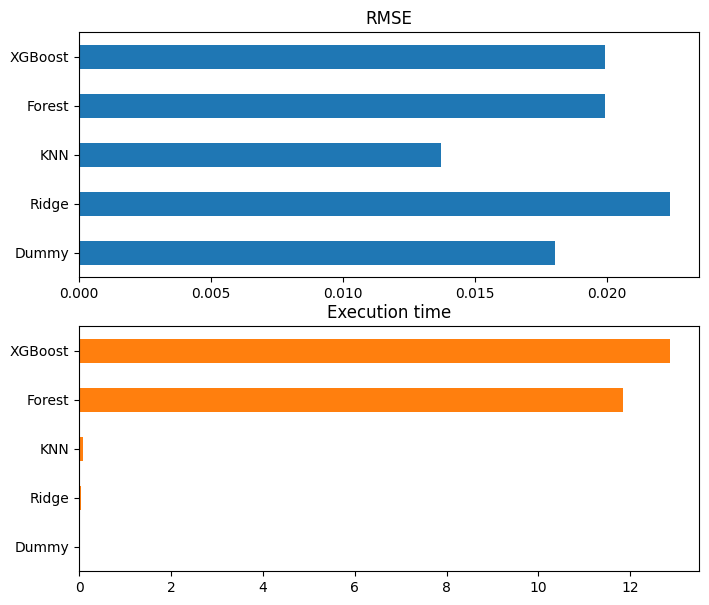

In [180]:
# Display the results
index = ['Dummy', 'Ridge', 'KNN', 'Forest', 'XGBoost']
em_results = pd.DataFrame(list(zip(em_rmse, em_elapsed)),
                          columns =['RMSE', 'Execution time'], index=index)

em_results.plot.barh(subplots=True, sharex=False, figsize=(8,7), legend=False)
plt.show()

The best model averaging low RMSE and low Exection time is the kNN regressor.

## 4.2. Energy consumption

### 4.2.1. Using the Energy Star Score

In [181]:
# Prepare the data using train_test_split
from sklearn import model_selection

X_en_train, X_en_test, y_en_train, y_en_test = model_selection.train_test_split(
    X_w_starscore, y_en, test_size=0.25, random_state=23)

In [182]:
# Initialize lists to store the results
en_w_ss_rmse = []
en_w_ss_elapsed = []

#### 4.2.1.1. Dummy Regressor

In [183]:
# Define the regressor
dum = DummyRegressor(strategy='mean')

# Call the function
RMSE_dum_en, elapsed_dum_en = perf_model(X_en_train, X_en_test,
                                         y_en_train, y_en_test,
                                         dum)

# Display and store the results
print(f'RMSE: {RMSE_dum_en:.2f}')
en_w_ss_rmse.append(RMSE_dum_en)
print(f'Execution time: {elapsed_dum_en:.2f}')
en_w_ss_elapsed.append(elapsed_dum_en)

RMSE: 0.02
Execution time: 0.01


#### 4.2.1.2. Ridge Regressor

In [184]:
%%time
# Start by looking for the best hyperparameters for the model

# Define the hyperparameters to look for
# 'lbfgs' not included because throws error
param_grid = {
    'solver':['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

# Define the regressor with hyperparameter lookup using cross validation
rr = model_selection.GridSearchCV(Ridge(random_state=23),
                                  param_grid=param_grid, scoring=score,
                                  n_jobs=-1, cv=5, verbose=5)

# Fit
rr.fit(X_en_train, y_en_train)

# Best model
print(f'Best model on training data: {rr.best_estimator_}')
# Best score
print(f'Best score on training data: {rr.best_score_}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best model on training data: Ridge(random_state=23, solver='svd')
Best score on training data: -0.030999192108739748
CPU times: user 1.61 s, sys: 104 ms, total: 1.72 s
Wall time: 5.27 s


In [187]:
# Call the function using the best model
RMSE_rr_en, elapsed_rr_en = perf_model(X_en_train, X_en_test,
                                       y_en_train, y_en_test,
                                       rr.best_estimator_)

# Display and store the results
print(f'RMSE: {RMSE_rr_en:.2f}')
en_w_ss_rmse.append(RMSE_rr_en)
print(f'Execution time: {elapsed_rr_en:.2f}')
en_w_ss_elapsed.append(elapsed_rr_en)

RMSE: 0.02
Execution time: 0.25


#### 4.2.1.3. kNN Regressor

In [186]:
%%time
# Start by looking for the best hyperparameters for the model

# Define the hyperparameters to look for
param_dist = {'n_neighbors':sp.stats.randint(3, 20),
              'weights':['uniform', 'distance'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'leaf_size':sp.stats.randint(10, 50)}

# Define the regressor with hyperparameter lookup using cross validation
knnR = model_selection.RandomizedSearchCV(KNeighborsRegressor(),
                                          param_distributions=param_dist,
                                          scoring=score, n_jobs=-1, cv=5,
                                          verbose=5, random_state=23)

# Fit
knnR.fit(X_en_train, y_en_train)

# Best model
print(f'Best model on training data: {knnR.best_estimator_}')
# Best score
print(f'Best score on training data: {knnR.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best model on training data: KNeighborsRegressor(algorithm='brute', leaf_size=49)
Best score on training data: -0.031820301344477414
CPU times: user 1.48 s, sys: 24 ms, total: 1.5 s
Wall time: 4.2 s


In [188]:
# Call the function using the best model
RMSE_knnR_en, elapsed_knnR_en = perf_model(X_en_train, X_en_test,
                                           y_en_train, y_en_test,
                                           knnR.best_estimator_)

# Display and store the results
print(f'RMSE: {RMSE_knnR_en:.2f}')
en_w_ss_rmse.append(RMSE_knnR_en)
print(f'Execution time: {elapsed_knnR_en:.2f}')
en_w_ss_elapsed.append(elapsed_knnR_en)

RMSE: 0.01
Execution time: 0.04


#### 4.2.1.4. Random Forest Regressor

In [189]:
%%time
# Start by looking for the best hyperparameters for the model

# Define the hyperparameters to look for
param_dist = {'n_estimators':sp.stats.randint(50, 1500)}

# Define the regressor with hyperparameter lookup using cross validation
treeR = model_selection.RandomizedSearchCV(RandomForestRegressor(oob_score=True,
                                                                 random_state=23),
                                           param_distributions=param_dist,
                                           scoring=score, n_jobs=-1, cv=5,
                                           verbose=5, random_state=23)

# Fit
treeR.fit(X_en_train, y_en_train)

# Best model
print(f'Best model on training data: {treeR.best_estimator_}')
# Best score
print(f'Best score on training data: {treeR.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best model on training data: RandomForestRegressor(n_estimators=715, oob_score=True, random_state=23)
Best score on training data: -0.02793074858861031
CPU times: user 22.3 s, sys: 947 ms, total: 23.2 s
Wall time: 6min 39s


In [190]:
# Call the function using the best model
RMSE_treeR_en, elapsed_treeR_en = perf_model(X_en_train, X_en_test,
                                             y_en_train, y_en_test,
                                             treeR.best_estimator_)

# Display and store the results
print(f'RMSE: {RMSE_treeR_en:.2f}')
en_w_ss_rmse.append(RMSE_treeR_en)
print(f'Execution time: {elapsed_treeR_en:.2f}')
en_w_ss_elapsed.append(elapsed_treeR_en)

RMSE: 0.02
Execution time: 14.00


#### 4.2.1.5. XGBoost Regressor

In [191]:
%%time
# Start by looking for the best hyperparameters for the model

# Define the hyperparameters to look for
param_dist = {'eta':sp.stats.uniform(0, 1),
              'max_depth':sp.stats.randint(2, 8)}

# Define the regressor with hyperparameter lookup using cross validation
xgbR = model_selection.RandomizedSearchCV(XGBRegressor(),
                                          param_distributions=param_dist,
                                          scoring=score, n_jobs=-1, cv=5,
                                          verbose=5, random_state=23)

# Fit
xgbR.fit(X_en_train, y_en_train)

# Best model
print(f'Best model on training data: {xgbR.best_estimator_}')
# Best score
print(f'Best score on training data: {xgbR.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best model on training data: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.5895818652147146, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)
Best score on training data: -0.031193673056531583
CPU times: user 2.8 s, sys: 54.4 ms, total: 2.86 s
Wall time: 8.18 s


In [192]:
# Call the function using the best model
RMSE_xgbR_en, elapsed_xgbR_en = perf_model(X_en_train, X_en_test,
                                           y_en_train, y_en_test,
                                           treeR.best_estimator_)

# Display and store the results
print(f'RMSE: {RMSE_xgbR_en:.2f}')
en_w_ss_rmse.append(RMSE_xgbR_en)
print(f'Execution time: {elapsed_xgbR_en:.2f}')
en_w_ss_elapsed.append(elapsed_xgbR_en)

RMSE: 0.02
Execution time: 12.41


### 4.2.2. Without the Energy Star Score

In [193]:
# Prepare the data using train_test_split
from sklearn import model_selection

X_en_train, X_en_test, y_en_train, y_en_test = model_selection.train_test_split(
    X_wo_starscore, y_en, test_size=0.25, random_state=23)

In [194]:
# Initialize lists to store the results
en_wo_ss_rmse = []
en_wo_ss_elapsed = []

#### 4.2.2.1. Dummy Regressor

In [195]:
# Define the regressor
dum = DummyRegressor(strategy='mean')

# Call the function
RMSE_dum_en, elapsed_dum_en = perf_model(X_en_train, X_en_test,
                                         y_en_train, y_en_test,
                                         dum)

# Display and store the results
print(f'RMSE: {RMSE_dum_en:.2f}')
en_wo_ss_rmse.append(RMSE_dum_en)
print(f'Execution time: {elapsed_dum_en:.2f}')
en_wo_ss_elapsed.append(elapsed_dum_en)

RMSE: 0.02
Execution time: 0.00


#### 4.2.2.2. Ridge Regressor

In [196]:
%%time
# Start by looking for the best hyperparameters for the model

# Define the hyperparameters to look for
# 'lbfgs' not included because throws error
param_grid = {
    'solver':['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

# Define the regressor with hyperparameter lookup using cross validation
rr = model_selection.GridSearchCV(Ridge(random_state=23),
                                  param_grid=param_grid, scoring=score,
                                  n_jobs=-1, cv=5, verbose=5)

# Fit
rr.fit(X_en_train, y_en_train)

# Best model
print(f'Best model on training data: {rr.best_estimator_}')
# Best score
print(f'Best score on training data: {rr.best_score_}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best model on training data: Ridge(random_state=23, solver='svd')
Best score on training data: -0.031141624775943975
CPU times: user 990 ms, sys: 45.7 ms, total: 1.04 s
Wall time: 2.31 s


In [197]:
# Call the function using the best model
RMSE_rr_en, elapsed_rr_en = perf_model(X_en_train, X_en_test,
                                       y_en_train, y_en_test,
                                       rr.best_estimator_)

# Display and store the results
print(f'RMSE: {RMSE_rr_en:.2f}')
en_wo_ss_rmse.append(RMSE_rr_en)
print(f'Execution time: {elapsed_rr_en:.2f}')
en_wo_ss_elapsed.append(elapsed_rr_en)

RMSE: 0.02
Execution time: 0.07


#### 4.2.2.3. kNN Regressor

In [198]:
%%time
# Start by looking for the best hyperparameters for the model

# Define the hyperparameters to look for
param_dist = {'n_neighbors':sp.stats.randint(3, 20),
              'weights':['uniform', 'distance'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'leaf_size':sp.stats.randint(10, 50)}

# Define the regressor with hyperparameter lookup using cross validation
knnR = model_selection.RandomizedSearchCV(KNeighborsRegressor(),
                                          param_distributions=param_dist,
                                          scoring=score, n_jobs=-1, cv=5,
                                          verbose=5, random_state=23)

# Fit
knnR.fit(X_en_train, y_en_train)

# Best model
print(f'Best model on training data: {knnR.best_estimator_}')
# Best score
print(f'Best score on training data: {knnR.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best model on training data: KNeighborsRegressor(algorithm='kd_tree', leaf_size=22, n_neighbors=10)
Best score on training data: -0.03095067346386991
CPU times: user 2.55 s, sys: 64.8 ms, total: 2.61 s
Wall time: 6.13 s


In [199]:
# Call the function using the best model
RMSE_knnR_en, elapsed_knnR_en = perf_model(X_en_train, X_en_test,
                                           y_en_train, y_en_test,
                                           knnR.best_estimator_)

# Display and store the results
print(f'RMSE: {RMSE_knnR_en:.2f}')
en_wo_ss_rmse.append(RMSE_knnR_en)
print(f'Execution time: {elapsed_knnR_en:.2f}')
en_wo_ss_elapsed.append(elapsed_knnR_en)

RMSE: 0.01
Execution time: 0.16


#### 4.2.2.4. Random Forest Regressor

In [200]:
%%time
# Start by looking for the best hyperparameters for the model

# Define the hyperparameters to look for
param_dist = {'n_estimators':sp.stats.randint(50, 1500)}

# Define the regressor with hyperparameter lookup using cross validation
treeR = model_selection.RandomizedSearchCV(RandomForestRegressor(oob_score=True,
                                                                 random_state=23),
                                           param_distributions=param_dist,
                                           scoring=score, n_jobs=-1, cv=5,
                                           verbose=5, random_state=23)

# Fit
treeR.fit(X_en_train, y_en_train)

# Best model
print(f'Best model on training data: {treeR.best_estimator_}')
# Best score
print(f'Best score on training data: {treeR.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best model on training data: RandomForestRegressor(n_estimators=1114, oob_score=True, random_state=23)
Best score on training data: -0.028178067083708132
CPU times: user 26.4 s, sys: 1.06 s, total: 27.5 s
Wall time: 6min 56s


In [201]:
# Call the function using the best model
RMSE_treeR_en, elapsed_treeR_en = perf_model(X_en_train, X_en_test,
                                             y_en_train, y_en_test,
                                             treeR.best_estimator_)

# Display and store the results
print(f'RMSE: {RMSE_treeR_en:.2f}')
en_wo_ss_rmse.append(RMSE_treeR_en)
print(f'Execution time: {elapsed_treeR_en:.2f}')
en_wo_ss_elapsed.append(elapsed_treeR_en)

RMSE: 0.02
Execution time: 20.97


#### 4.2.2.5. XGBoost Regressor

In [202]:
%%time
# Start by looking for the best hyperparameters for the model

# Define the hyperparameters to look for
param_dist = {'eta':sp.stats.uniform(0, 1),
              'max_depth':sp.stats.randint(2, 8)}

# Define the regressor with hyperparameter lookup using cross validation
xgbR = model_selection.RandomizedSearchCV(XGBRegressor(),
                                          param_distributions=param_dist,
                                          scoring=score, n_jobs=-1, cv=5,
                                          verbose=5, random_state=23)

# Fit
xgbR.fit(X_en_train, y_en_train)

# Best model
print(f'Best model on training data: {xgbR.best_estimator_}')
# Best score
print(f'Best score on training data: {xgbR.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best model on training data: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.5895818652147146, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)
Best score on training data: -0.031623544308006526
CPU times: user 2.84 s, sys: 106 ms, total: 2.95 s
Wall time: 9.59 s


In [203]:
# Call the function using the best model
RMSE_xgbR_en, elapsed_xgbR_en = perf_model(X_en_train, X_en_test,
                                           y_en_train, y_en_test,
                                           treeR.best_estimator_)

# Display and store the results
print(f'RMSE: {RMSE_xgbR_en:.2f}')
en_wo_ss_rmse.append(RMSE_xgbR_en)
print(f'Execution time: {elapsed_xgbR_en:.2f}')
en_wo_ss_elapsed.append(elapsed_xgbR_en)

RMSE: 0.02
Execution time: 20.96


### 4.2.3. Performances and interest of Energy Star Score

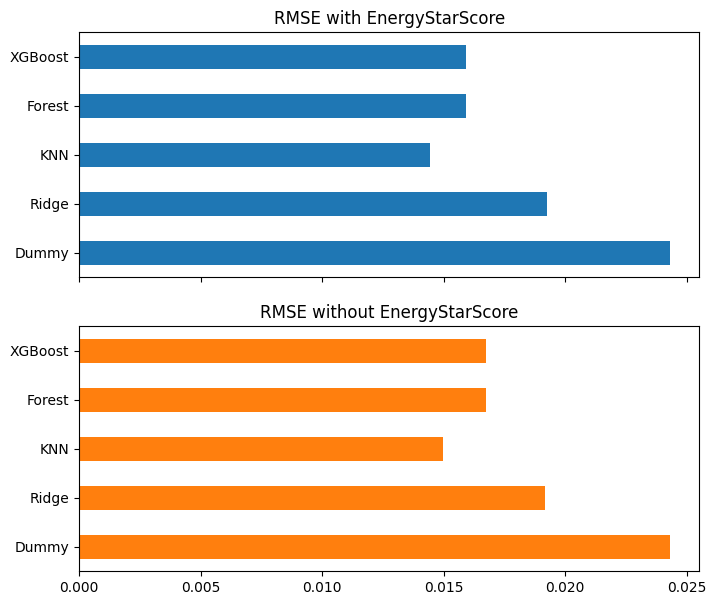

In [207]:
# First compare the RMSE
index = ['Dummy', 'Ridge', 'KNN', 'Forest', 'XGBoost']
en_RMSE = pd.DataFrame(list(zip(en_w_ss_rmse, en_wo_ss_rmse)),
                       columns =['RMSE with EnergyStarScore',
                                 'RMSE without EnergyStarScore'], index=index)

en_RMSE.plot.barh(subplots=True, sharex=True, figsize=(8,7), legend=False)
plt.show()

There is a little improvement, but it is worth the trouble of calculating the Energy Star Score?

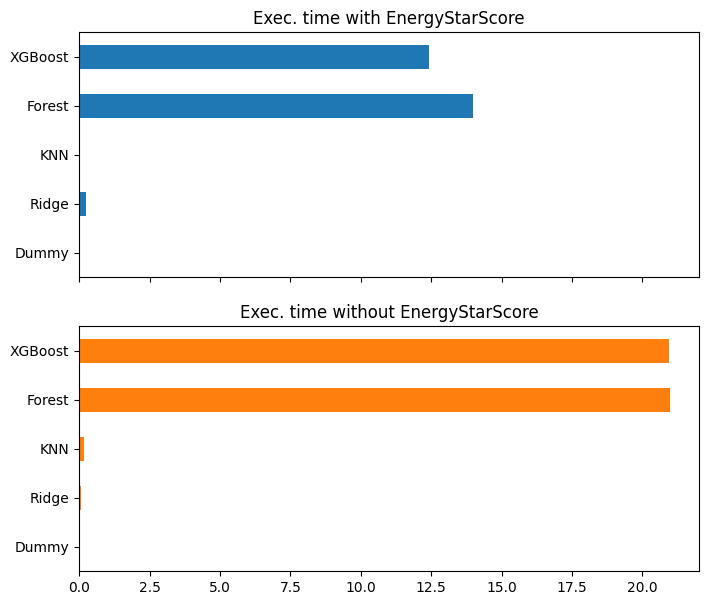

In [208]:
# Compare the execution time
index = ['Dummy', 'Ridge', 'KNN', 'Forest', 'XGBoost']
en_elapsed = pd.DataFrame(list(zip(en_w_ss_elapsed, en_wo_ss_elapsed)),
                          columns =['Exec. time with EnergyStarScore',
                                    'Exec. time without EnergyStarScore'],
                          index=index)

en_elapsed.plot.barh(subplots=True, sharex=True, figsize=(8,7), legend=False)
plt.show()